## Анализ бизнес-показателей

### Содержание

1. [Введение](#introduction)  
2. [Загрузка данных и первичный обзор](#read)  
3. [Предобработка данных](#preprocessing)  
4. [Продуктовые метрики](#product_metrics)  
    4.1. [DAU, WAU и MAU](#dau_mau_wau)  
    4.2. [Среднее количество посещений на одного пользователя в день](#average_daily_using)  
    4.3. [Продолжительность сессий](#session_duration)  
    4.4. [Retention Rate](#retention_rate)  
5. [Метрики электронной коммерции](#digital_marketing)  
    5.1. [Среднее время от момента первого посещения до первой покупки](#first_purchase)  
    5.2. [Среднее количество покупок на одного покупателя за 6 месяцев](#count_purchase)  
    5.3. [Средний чек](#average_purchase)  
    5.4. [Life Time Value](#ltv)  
6. [Маркетинговые метрики](#mark_metrics)  
    6.1. [Траты по источникам](#source_cost)  
    6.2. [Customer Acquisition Cost](#cac)  
    6.3. [Return on Marketing Investment](#romi)  
7. [Выводы и рекомендации](#conclusions)  

### 1. Введение <a id='introduction'> </a>

**Заказчик**: Отдел маркетинговой аналитики Яндекс.Афиши.  
  
**Цель**: Снижение расходов, через выявление невыгодных источников трафика для последующего перераспределения бюджета.  
  
**Объект**: Данные Яндекс.Афиши с июня 2017 по конец мая 2018 года.  

#### Описание данных

Структура `visits_log.csv`  
  
* `Uid` — уникальный идентификатор пользователя,  
* `Device` — категория устройства пользователя,  
* `Start Ts` — дата и время начала сессии,  
* `End Ts` — дата и время окончания сессии,  
* `Source Id` — идентификатор источника перехода на сайт.

Структура `orders_log.csv`  
  
* `Uid` — уникальный идентификатор пользователя,  
* `Buy Ts` — дата и время заказа,  
* `Revenue` — сумма заказа.

Структура `costs.csv`  
  
* `source_id` — идентификатор рекламного источника,  
* `dt` — дата проведения рекламной кампании,  
* `costs` — расходы на эту кампанию.

### 2. Подготовка среды, загрузка данных и первичный обзор <a id='read'> </a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from scipy import stats as st
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("display.max_columns", None)
%matplotlib inline

In [2]:
# цвета для диаграмм
low_c = '#dd4124'
high_c = '#009473'
medium_c = '#3c93d6'
v_c = '#9700bd'
plt.rcParams["font.family"] = "monospace"
background_color = "#fafafa"

Загружу данные и присвою им соответствующие наименования

In [3]:
try:
    visits = pd.read_csv('/datasets/visits_log.csv')
except:
    visits = pd.read_csv('visits_log.csv')

In [4]:
try:
    orders = pd.read_csv('/datasets/orders_log.csv')
except:
    orders = pd.read_csv('orders_log.csv')

In [5]:
try:
    costs = pd.read_csv('/datasets/costs.csv')
except:
    costs = pd.read_csv('costs.csv')

Поочередно посмотрю датасеты и сделаю первичные выводы

In [6]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [7]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [8]:
visits.Device.value_counts()

desktop    262567
touch       96833
Name: Device, dtype: int64

In [9]:
visits['Source Id'].value_counts()

4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: Source Id, dtype: int64

Датасет `visits` представляет собой лог, в которм зафиксированы посещения сайта с указанием начала и конца сессии, устройства с которого проводилась сессия и идентификатор пропуска. Устройств всего два - это десктопное устройство и устройство с тач-скрином. Предполагаю, что это планшет или телефон. Хотя сейчас имеются ноутбуки с тачскрином. Не думаю, что это может играть важную роль.  
  
Источников трафика 7. Самый популярный это 4, самый непопулярный 6
  
Пропусков в данных нет. На стадии предобработки приведу наименование колонок к нижнему регистру и пробелы поменяю на нижнее подчеркивание, чтобы было удобней работать. Даты к формату `datetime`

In [10]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [12]:
orders['Revenue'].describe()

count   50,415.00
mean         5.00
std         21.82
min          0.00
25%          1.22
50%          2.50
75%          4.89
max      2,633.28
Name: Revenue, dtype: float64

Датасет `orders` представляет собой лог с заказами произведенными на сайте и выручкой от них.  
  
Средний заказ составляет 5 у.е., а медиана 2,5. Такую разницу можно объяснить выбросами. Как видно максимальный заказ составляет 2,633.28 у.е., что очень много относительно других заказов.  
  
В данных пропусков нет, единственное, нужно привести наименование колонок к нижнему регистру и даты к форматы `datetime`

In [13]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [14]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [15]:
costs.costs.describe()

count   2,542.00
mean      129.48
std       156.30
min         0.54
25%        21.95
50%        77.30
75%       170.06
max     1,788.28
Name: costs, dtype: float64

In [16]:
costs.source_id.value_counts()

5     364
9     363
3     363
1     363
10    363
4     363
2     363
Name: source_id, dtype: int64

Датасет `costs` содержит информацию о расходах на маркетинг. Целью расходов являются источники трафика. Средняя сумма расходов 129.48 у.е., медиана при этом 77.3 у.е. Опять же вина этому выбросы.  
  
Количество трансфертов на источники трафика распределены равномерно. 363 траснферта на 6 источников и 364 на 5 источник.  
  
Пропусков в данных нет. Остается только привести даты к формату `datetime`

### 3. Предобработка данных <a id='preprocessing'> </a>

Приведу данные всех трех датасетов к рабочему виду

In [17]:
visits.columns = [
    'device',
    'end_ts',
    'source_id',
    'start_ts',
    'uid'
]

In [18]:
orders.columns = [
    'buy_ts',
    'revenue',
    'uid'
]

In [19]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])

In [20]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

In [21]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [22]:
costs['dt'] = pd.to_datetime(costs['dt'])

Проверю данные на соответствие заданному интервалу

In [23]:
visits.end_ts.describe()

count                  359400
unique                 224760
top       2017-11-24 16:51:00
freq                       23
first     2017-06-01 00:02:00
last      2018-06-01 01:26:00
Name: end_ts, dtype: object

In [24]:
orders.buy_ts.describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

In [25]:
costs.dt.describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

Было заявлено, что данные по конец мая, но как видно датасеты `visits` и `orders` захватывают немного и первое июня 2018 года. Не думаю, что это проблема. Можно продолжать дальше.  
  
Проверю данные на дубликаты

In [26]:
visits.duplicated().sum()

0

In [27]:
orders.duplicated().sum()

0

In [28]:
costs.duplicated().sum()

0

Дубликатов не выявлено. Данные предобработаны. Теперь можно приступать к анализу

### 4. Продуктовые метрики <a id='product_metrics'> </a>

#### 4.1. DAU, WAU и MAU <a id='dau_mau_wau'> </a>

Расчитаю метрики DAU, WAU и MAU.  
  
Для этого сначала выделим в отдельные столбцы год, месяц и неделю, а также полную дату.

In [29]:
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date

In [30]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


In [31]:
dau_total = visits.groupby('session_date', as_index=False) \
    .agg({'uid': 'nunique'}) \
    .rename(columns={'uid' : 'dau_count'})

In [32]:
wau_total = visits.groupby(['session_year', 'session_week'], as_index=False) \
    .agg({'uid': 'nunique'}) \
    .rename(columns={'uid' : 'wau_count'})

In [33]:
mau_total = visits.groupby(['session_year', 'session_month'], as_index=False) \
    .agg({'uid': 'nunique'}) \
    .rename(columns={'uid' : 'mau_count'})

Найду средние значения метрик

In [34]:
int(dau_total.dau_count.mean())

907

In [35]:
int(wau_total.wau_count.mean())

5716

In [36]:
int(mau_total.mau_count.mean())

23228

Нирисую диаграммы для каждой из них, чтобы увидеть изменения во времени

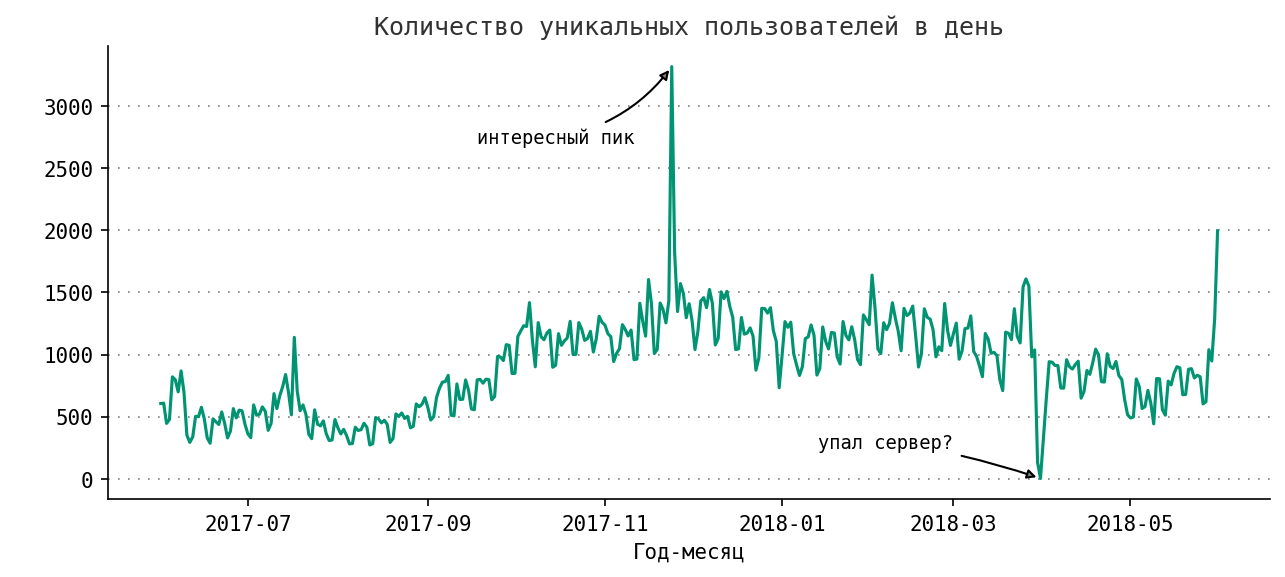

In [37]:
fig = plt.figure(figsize=(10, 4), dpi=150,facecolor='white')

# Сетка будет из одного графика
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0)

ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor('white')
ax0.grid(color='black', linestyle=':', axis='y', dashes=(1,5), alpha=0.5)
for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)

ax0.set_title('Количество уникальных пользователей в день', fontfamily='monospace', color='#323232')
ax0.set_xlabel('Год-месяц', fontfamily='monospace')
ax0.set_ylabel(' ')
ax0.tick_params(axis = 'both', which = 'major', labelsize = 10)

sns.lineplot(ax=ax0,data=dau_total, x='session_date', y='dau_count',color=high_c)

# укажу на интересные пики и провалы
plt.annotate('интересный пик',
             xy=('2017-11-24', 3319),
             xytext=('2017-10-15', 2700),
             arrowprops=dict(
                 facecolor='gray',
                 arrowstyle="-|>",
                 connectionstyle="arc3,rad=.2"
             ),
             fontsize=9,
             fontfamily='monospace',
             fontweight='light',
             ha='center',
             color='black')

plt.annotate('упал сервер?',
             xy=('2018-03-31', 1),
             xytext=('2018-03-01', 250),
             arrowprops=dict(
                 facecolor='gray',
                 arrowstyle="-|>",
                 connectionstyle="arc3,rad=-.05"
             ),
             fontsize=9,
             fontfamily='monospace',
             fontweight='light',
             ha='right',
             color='black')

plt.show()

Теперь WAU. Чтобы линия была выстроена в хронологическом порядке, объединю год и порядковый номер недели

In [38]:
def yearweek(row):
    year = row[0]
    week = row[1]
    year_week = str(year)+'-'+str(week)
    return year_week

In [39]:
wau_total['year_week'] = wau_total[['session_year', 'session_week']].apply(yearweek, axis=1)

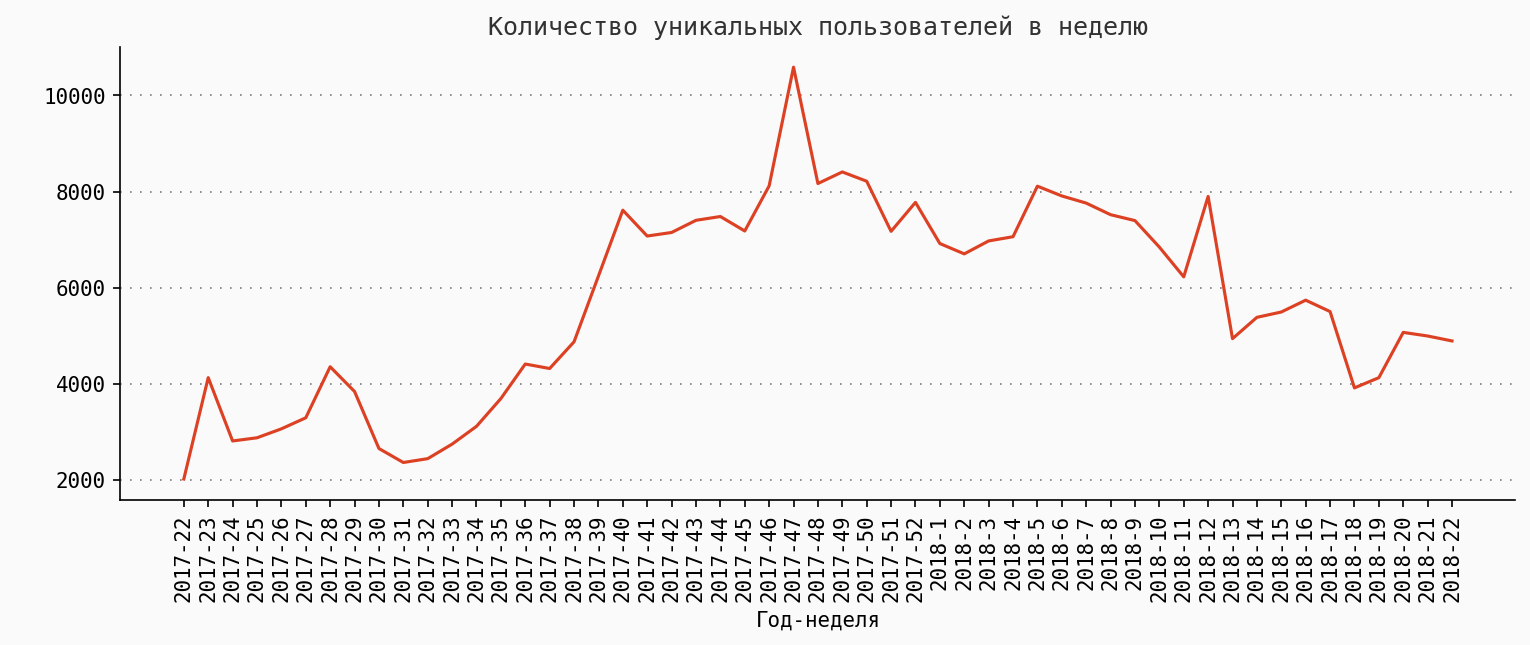

In [40]:
fig = plt.figure(figsize=(12, 4), dpi=150,facecolor=background_color)

gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(background_color)
ax0.grid(color='black', linestyle=':', axis='y', dashes=(1,5), alpha=0.5)
for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)

sns.lineplot(ax=ax0,data=wau_total, x=wau_total.index, y='wau_count', color=low_c)

ax0.set_title('Количество уникальных пользователей в неделю', fontfamily='monospace', color='#323232')
ax0.set_xlabel('Год-неделя', fontfamily='monospace',)
ax0.set_ylabel(' ')
ax0.tick_params(axis = 'x', which = 'both', labelsize = 10)

ax0.set_xticks(ticks=np.arange(0, len(wau_total.year_week), 1))
ax0.set_xticklabels(wau_total['year_week'], rotation=90)


plt.show()

Ну и MAU. Опять же объединю год и месяц. Воспользуюсь уже написаной функцией для недель.

In [41]:
mau_total['year_month'] = mau_total[['session_year', 'session_month']].apply(yearweek, axis=1)

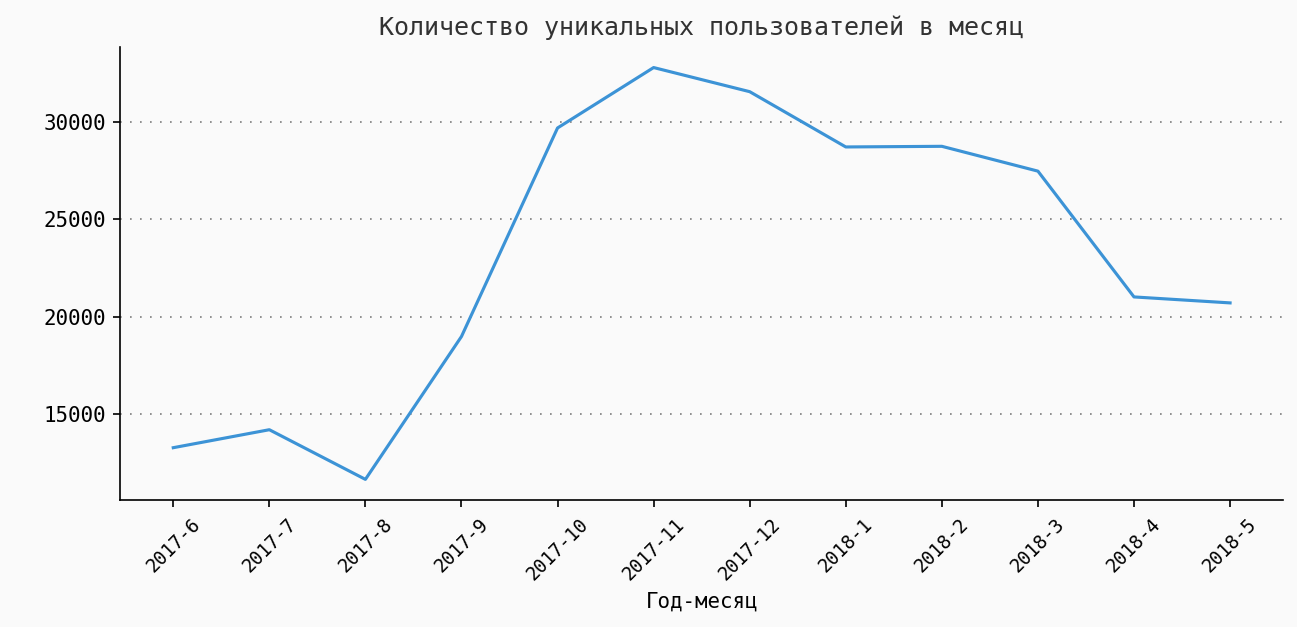

In [42]:
fig = plt.figure(figsize=(10, 4), dpi=150,facecolor=background_color)

gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(background_color)
ax0.grid(color='black', linestyle=':', axis='y', dashes=(1,5), alpha=0.5)
for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)

sns.lineplot(ax=ax0,data=mau_total, x=mau_total.index, y='mau_count', color=medium_c)

ax0.set_title('Количество уникальных пользователей в месяц', fontfamily='monospace', color='#323232')
ax0.set_xlabel('Год-месяц', fontfamily='monospace')
ax0.set_ylabel(' ')
ax0.tick_params(axis = 'x', which = 'both', labelsize = 9)

ax0.set_xticks(ticks=np.arange(0, len(mau_total.year_month), 1))
ax0.set_xticklabels(mau_total['year_month'], rotation=45)

plt.show()

#### 4.2. Среднее количество посещений на одного пользователя в день <a id='average_daily_using'> </a>

Для того, чтобы посчитать количество сессий в день, сгруппирую по дате и посчитаю количество пользователей и количество уникальных пользователей.

In [43]:
daily_sessions = visits.groupby('session_date', as_index=False) \
    .agg({'uid': ['count', 'nunique']})

In [44]:
daily_sessions.columns = ['session_date', 'n_sessions', 'n_users']

Теперь добавлю новую колонку в котором будет значение количества сессий на одного пользователя

In [45]:
daily_sessions['session_per_user'] = daily_sessions['n_sessions'] / daily_sessions['n_users']

Среднее количество сессий при этом равно

In [46]:
round(daily_sessions.session_per_user.mean(), 2)

1.08

Нарисую график количества сессий в день, где синей пунктирной линией будет показано среднее значение в 1.08 посещений

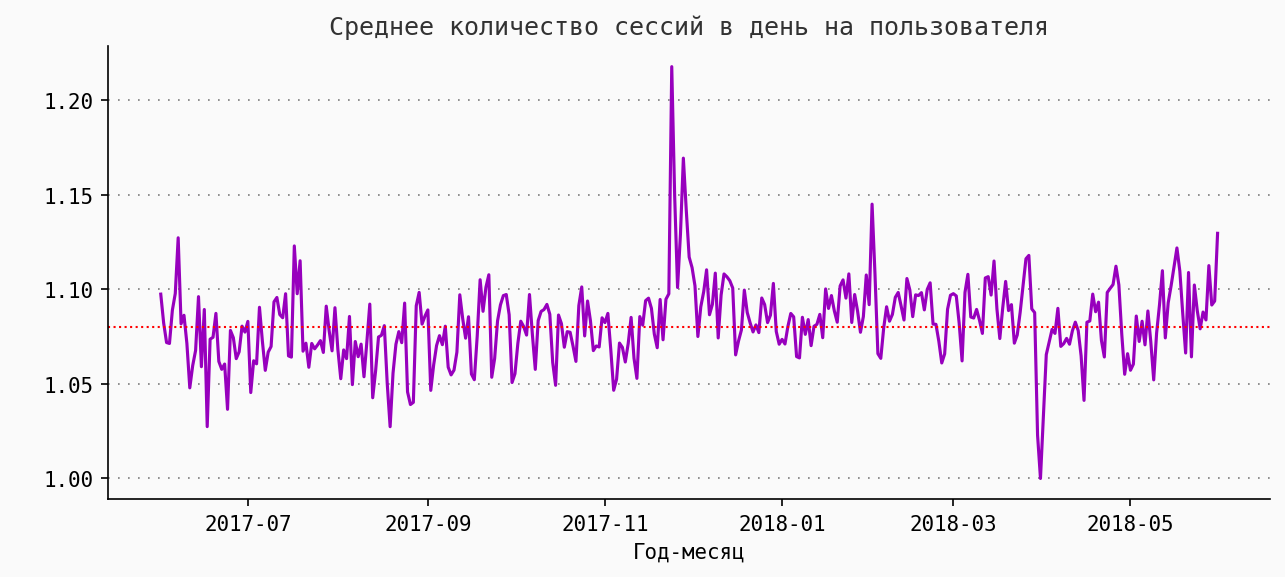

In [47]:
fig = plt.figure(figsize=(10, 4), dpi=150,facecolor=background_color)

gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(background_color)
ax0.grid(color='black', linestyle=':', axis='y', dashes=(1,5), alpha=0.5)
for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)

sns.lineplot(ax=ax0,data=daily_sessions, x='session_date', y='session_per_user',color=v_c)

ax0.set_title('Среднее количество сессий в день на пользователя', fontfamily='monospace', color='#323232')
ax0.set_xlabel('Год-месяц', fontfamily='monospace')
ax0.set_ylabel(' ')
ax0.tick_params(axis = 'both', which = 'major', labelsize = 10)

ax0.axhline(y=1.08, ls=':', lw='1', ds='steps', c='red')

plt.show()

#### 4.3. Продолжительность сессий <a id='session_duration'> </a>

В датасет `visits` добавлю колонку с продолжительностью сессий в секундах

In [48]:
visits['session_duration_sec'] = (
    visits['end_ts'] - visits['start_ts']
).dt.seconds

In [49]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0


Построю распределение по продолжительности сессий исключив нулевые сессии. На основании распределения выберу адекватную меру оценки типичной пользовательской сессии

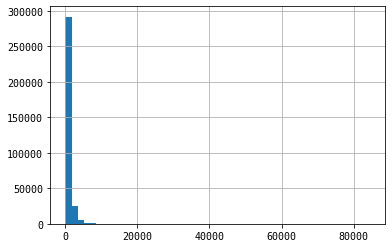

In [50]:
visits[visits['session_duration_sec'] != 0]['session_duration_sec'].hist(bins=50)
plt.show()

Распределение далеко от нормального. Поэтому в данном случае релевантной мерой для оценки типичной пользовательской активности будет являться мода

In [51]:
visits[visits['session_duration_sec'] != 0]['session_duration_sec'].mode()[0]

60

Одна минута - это типичная пользовательская сессия

#### 4.4. Retention Rate <a id='retention_rate'> </a>

Чтобы посчитать Retention Rate, для начала определю, когда пользователь впервые проявил активность. Создам датасет в котором для каждого пользователя будет дата первого посещения. Когорты возьму периодом в 1 месяц, поэтому округлю дату первого посещения до месяца

In [52]:
first_activity = visits.groupby('uid')['start_ts'].min()

In [53]:
first_activity.name = 'first_activity_month'

In [54]:
first_activity = first_activity.astype('datetime64[M]')

In [55]:
first_activity.head()

uid
11863502262781    2018-03-01
49537067089222    2018-02-01
297729379853735   2017-06-01
313578113262317   2017-09-01
325320750514679   2017-09-01
Name: first_activity_month, dtype: datetime64[ns]

Объединю получившийся датасет с `visits`

In [56]:
visits = visits.merge(first_activity, on='uid')

In [57]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec,first_activity_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-01
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,3,10,2018-03-09,1680,2018-03-01


Теперь расчитаю lifetime

In [58]:
visits['cohort_lifetime'] = (
    visits['session_date'].astype('datetime64[M]')
    - visits['first_activity_month']
)
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

In [59]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec,first_activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,3,10,2018-03-09,1680,2018-03-01,0


Теперь сгруппируем кагорты и посчитаем количество уникальных пользователей в каждый месяц жизни

In [60]:
cohorts = visits.groupby(['first_activity_month', 'cohort_lifetime']) \
    .agg({'uid' : 'nunique'}) \
    .rename({'uid' : 'users'}, axis=1) \
    .reset_index()

In [61]:
cohorts.head()

,first_activity_month,cohort_lifetime,users
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


Теперь нужно получить число пользователей, изначально бывших в когорте.  
Найдём исходное количество пользователей в когорте. Возьмём их число на нулевой месяц:

In [62]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month', 'users']]
initial_users_count = initial_users_count.rename(columns={'users' : 'initial_users'})
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')

Теперь рассчитаю Retention Rate поделив нынешнее количество пользователей на изначальное

In [63]:
cohorts['retention'] = cohorts['users'] / cohorts['initial_users']

Воспользуюсь методом визуализации heatmap, чтобы продемонстрировать удержание пользователей. Для этого необходимо создать сводную таблицу

In [64]:
retention_pivot = cohorts.pivot_table(
    index='first_activity_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum'
)

In [65]:
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,1.00,0.08,0.05,0.06,0.07,0.07,0.06,0.06,0.05,0.05,0.04,0.04
2017-07-01,1.00,0.06,0.05,0.06,0.06,0.05,0.05,0.05,0.04,0.03,0.03,nan
2017-08-01,1.00,0.08,0.06,0.06,0.05,0.04,0.04,0.04,0.03,0.03,nan,nan
2017-09-01,1.00,0.09,0.07,0.05,0.04,0.04,0.04,0.02,0.02,nan,nan,nan
2017-10-01,1.00,0.08,0.05,0.04,0.03,0.03,0.02,0.02,nan,nan,nan,nan
2017-11-01,1.00,0.08,0.04,0.04,0.03,0.02,0.02,nan,nan,nan,nan,nan
2017-12-01,1.00,0.06,0.04,0.03,0.02,0.02,nan,nan,nan,nan,nan,nan
2018-01-01,1.00,0.06,0.04,0.02,0.02,nan,nan,nan,nan,nan,nan,nan
2018-02-01,1.00,0.06,0.03,0.02,nan,nan,nan,nan,nan,nan,nan,nan


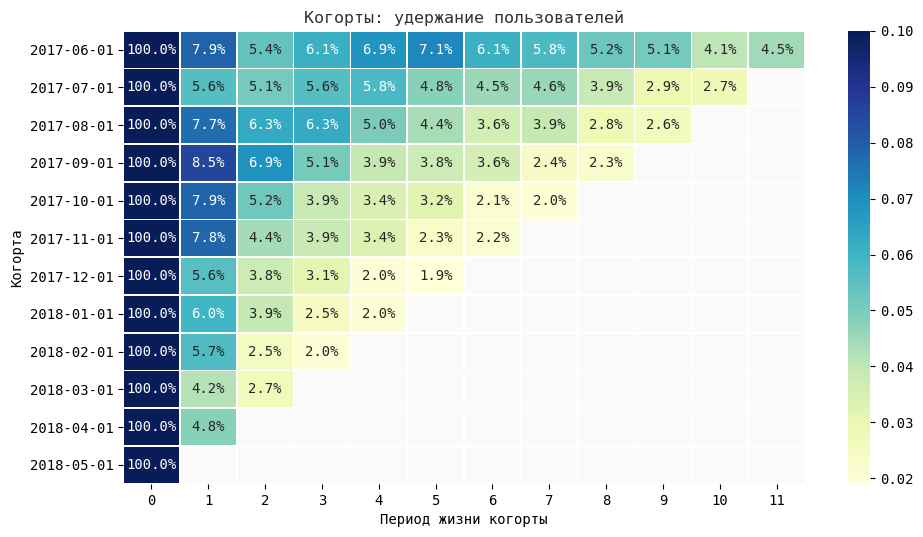

In [66]:
fig = plt.figure(figsize=(11, 6), dpi=100)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.2, hspace=0.4)
ax0 = fig.add_subplot(gs[0, 0])

background_color = background_color
fig.patch.set_facecolor('white') # figure background color
ax0.set_facecolor(background_color)

ticks_labels = list(cohorts['first_activity_month'].astype('datetime64[M]').astype(str).unique())
ax0.set_title('Когорты: удержание пользователей', fontfamily='monospace', color='#323232')

sns.heatmap(ax=ax0,
            data=retention_pivot,
            yticklabels=ticks_labels,
            xticklabels=True,
            annot=True,
            fmt='.1%',
            linewidths=0.5,
            cmap="YlGnBu",
            vmax=0.1 # установлю лимит, так как падение после первого месяца существенное, поэтому цвета не отражают разницы
           )

ax0.set_xlabel('Период жизни когорты', fontfamily='monospace')
ax0.set_ylabel('Когорта')

plt.show()

Также найду средний Retention Rate на второй месяц жизни когорт:

In [67]:
round(retention_pivot[1].mean(), 2)

0.07

Удержание пользователей на второй месяц жизни когорты составляет всего 7%, что очень плохо.

### 5. Метрики электронной коммерции <a id='digital_marketing'> </a>

#### 5.1. Среднее время от момента первого посещения до первой покупки <a id='first_purchase'> </a>

Для того, чтобы вычислить сколько времени проходит с момента первого посещения до первой покупки, я создам два датафрейма. Первый будет сгруппированный по пользователям и их первой активности на основе датасета `visits`

In [68]:
first_activity_for_order = visits.groupby('uid', as_index=False)['start_ts'].min()

Второй сгруппированный по пользователям и их первой покупке на основе датасета `orders`

In [69]:
first_orders = orders.groupby('uid', as_index=False)['buy_ts'].min()

Объеденю их и переименную колонки

In [70]:
first_activity_for_order = first_activity_for_order.merge(first_orders, on='uid')

In [71]:
first_activity_for_order.columns = ['uid', 'first_activity', 'first_purchase']

In [72]:
first_activity_for_order.head()

,uid,first_activity,first_purchase
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


Далее вычту разницу. Как видно из первых строк разница между первой активностью и первой покупкой может занимать как и месяцы, так и несколько минут. Поэтому я не будут округлять до какой либо временной меры, а оставлю как есть.

In [73]:
first_activity_for_order['difference'] = first_activity_for_order['first_purchase'] - first_activity_for_order['first_activity']

Ну а теперь посмотрим на то что получилось

In [74]:
first_activity_for_order.difference.describe()

count                         36523
mean     16 days 21:40:10.550064402
std      47 days 01:44:46.481416776
min                 0 days 00:00:00
25%                 0 days 00:04:00
50%                 0 days 00:16:00
75%                 2 days 00:17:00
max               363 days 07:04:00
Name: difference, dtype: object

Среднее время покупки занимает практически 17 дней, но среднему верить нельзя, ведь судя по максимальному значению некоторым пользователям и года мало для совершения первой покупки. Лучше обратите внимание на медиану. Она говорит, что пользователи тратят лишь 16 минут с момента первой активности до первой покупки.  
  
Для наглядности покажу данные в секундах на гистограмме

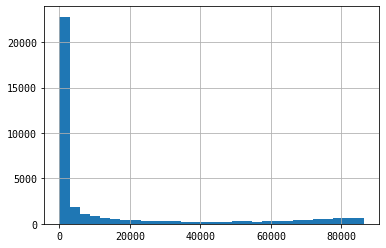

In [75]:
first_activity_for_order.difference.dt.seconds.hist(bins=30)

plt.show()

#### 5.2. Среднее количество покупок на одного покупателя за 6 месяцев <a id='count_purchase'> </a>

Для того, чтобы посчитать среднее количество покупок за 6 месяцев для одного покупателя, сначала создам порог даты, чтобы сделать срез

In [76]:
threshold_date = orders.buy_ts.min() + pd.DateOffset(months=6)

Далее сгруппирую пользователей среза и посчитаю количество покупок

In [77]:
orders_count = orders[orders['buy_ts'] < threshold_date][['revenue', 'uid']] \
    .groupby('uid', as_index=False) \
    .agg({'revenue' : 'count'}) \
    .rename({'revenue' : 'purchases'}, axis=1)

In [78]:
orders_count.head()

,uid,purchases
0,1575281904278712,2
1,2429014661409475,1
2,2551852515556206,2
3,3605148382144603,3
4,5081614443770358,1


Теперь выведу цифры

In [79]:
orders_count.purchases.describe()

count   16,318.00
mean         1.30
std          2.42
min          1.00
25%          1.00
50%          1.00
75%          1.00
max        157.00
Name: purchases, dtype: float64

Среднее количество покупок для одного пользователя составляе 1.3. При этом медианное количество покупок 1. Максимально за 6 месяцев один пользователь совершил 157 покупок, поэтому среднее значение отличается от медианого

#### 5.3. Средний чек <a id='average_purchase'> </a>

Для того, чтобы расчитать месячный средний чек создам в датасете `orders` колонку с месяцем. Далее сгруппирую данные по месяцам, и покажу среднуюю выручку в месяц.

In [80]:
orders['month'] = orders['buy_ts'].astype('datetime64[M]')

In [81]:
orders_average_purchase = orders.groupby('month', as_index=False) \
    .agg({'revenue' : 'mean'}) \
    .rename({'revenue' : 'average'}, axis=1)

In [82]:
orders_average_purchase.head()

,month,average
0,2017-06-01,4.06
1,2017-07-01,5.31
2,2017-08-01,4.85
3,2017-09-01,5.42
4,2017-10-01,4.93


Теперь покажу на линейном графике изменение среднего чека во времени. Прямой зеленой линией будет виден средний чек за весь период.

In [83]:
round(orders_average_purchase.average.mean(), 2) #средний чек за весь период

4.84

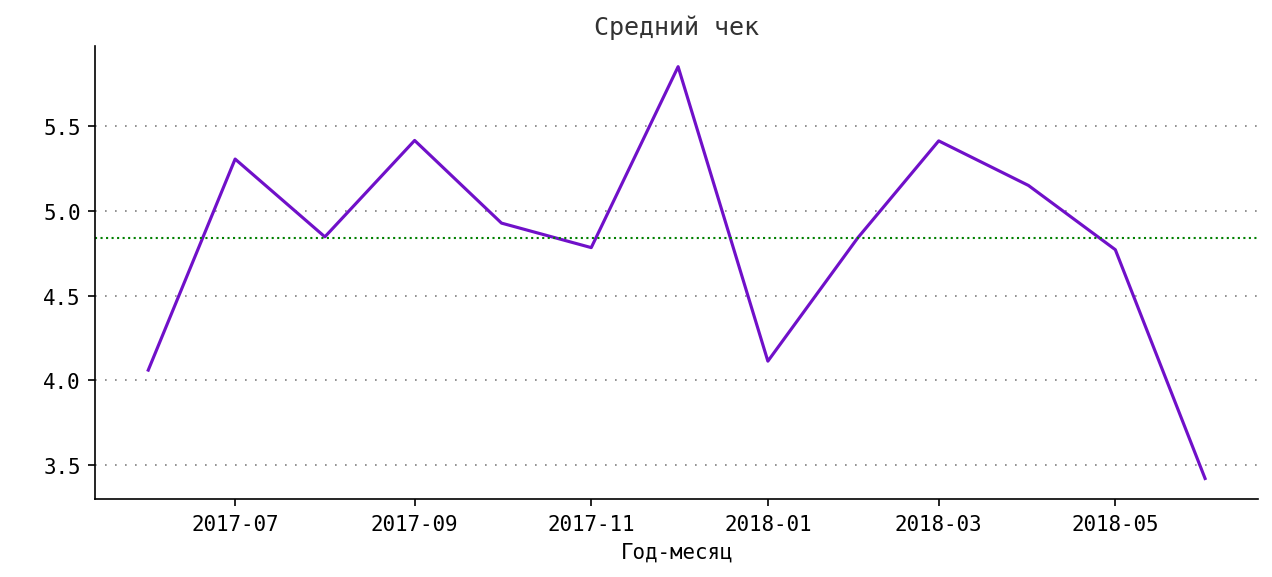

In [84]:
fig = plt.figure(figsize=(10, 4), dpi=150,facecolor='white')

gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor('white')
ax0.grid(color='black', linestyle=':', axis='y', dashes=(1,5), alpha=0.5)
for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)

ax0.set_title('Средний чек', fontfamily='monospace', color='#323232')
ax0.set_xlabel('Год-месяц', fontfamily='monospace')
ax0.set_ylabel(' ')
ax0.tick_params(axis = 'both', which = 'major', labelsize = 10)

sns.lineplot(ax=ax0,data=orders_average_purchase, x='month', y='average',color='#7010c9')

ax0.axhline(y=4.84, ls=':', lw='1', ds='steps', c='green')

plt.show()

#### 5.4. Life time value <a id='ltv'> </a>

Расчитаю показатель LTV. Для этого сначала найду первый месяц покупки

In [85]:
first_orders = orders \
    .groupby('uid', as_index=False) \
    .agg({'month': 'min'}) \
    .rename({'month' : 'first_month'}, axis=1)

И посчитаю количество новых покупателей за каждое время

In [86]:
cohort_sizes = (
    first_orders.groupby('first_month', as_index=False)
    .agg({'uid': 'nunique'})
)
cohort_sizes.columns = ['first_month', 'n_buyers']

Объединю с датасетом `orders`

In [87]:
orders = orders.merge(first_orders, on='uid')

И посчитаю сумму по сгруппированным месяцам

In [88]:
cohorts_ltv = orders \
    .groupby(['first_month', 'month'], as_index=False) \
    .agg({'revenue' : 'sum'})

In [89]:
report = pd.merge(
    cohort_sizes,
    cohorts_ltv,
    on='first_month'
)

Так как маржинальность равна 100%, то вся выручка будет равна валовой прибыли.  
  
Посчитаю возраст каждой когорты

In [90]:
report['age'] = (
    report['month'] - report['first_month']
) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

Найду LTV

In [91]:
report['ltv'] = report['revenue'] / report['n_buyers']

Покажу на тепловой диаграмме распределение LTV по когортам

In [92]:
ltv_heatmap = report.pivot_table(
    index='first_month',
    columns='age',
    values='ltv',
    aggfunc='mean'
)

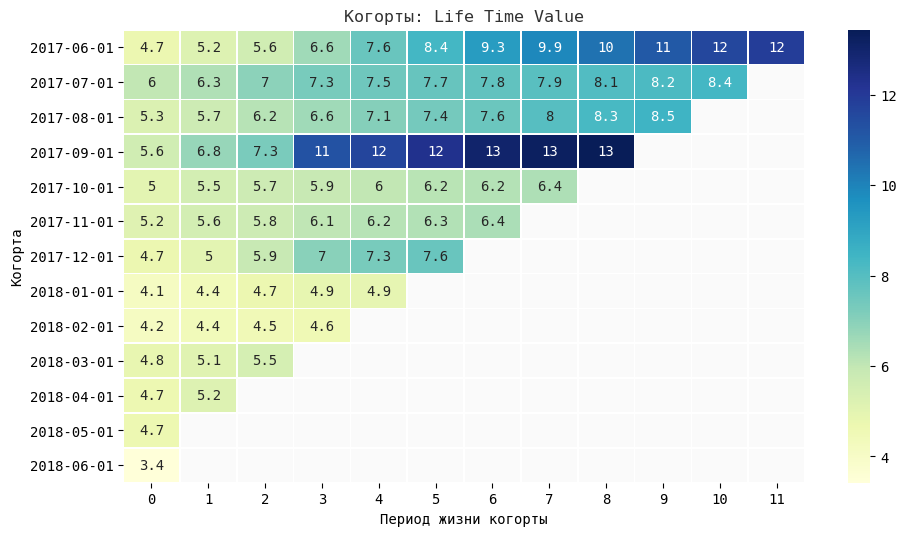

In [93]:
fig = plt.figure(figsize=(11, 6), dpi=100)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.2, hspace=0.4)
ax0 = fig.add_subplot(gs[0, 0])

background_color = background_color
fig.patch.set_facecolor('white') # figure background color
ax0.set_facecolor(background_color)

ticks_labels = list(report['first_month'].astype('datetime64[M]').astype(str).unique())
ax0.set_title('Когорты: Life Time Value', fontfamily='monospace', color='#323232')

sns.heatmap(ax=ax0,
            data=ltv_heatmap.cumsum(axis=1),
            yticklabels=ticks_labels,
            xticklabels=True,
            annot=True,
            linewidths=0.5,
            cmap="YlGnBu"
           )

ax0.set_xlabel('Период жизни когорты', fontfamily='monospace')
ax0.set_ylabel('Когорта')

plt.show()

По условию у когорт должно быть как минимум 6 полных месяце жизни. Сделаю срез

In [94]:
report = report.query('first_month < "2018-01-01" and age < 6')

Для наглядности выведу сводную таблицу c нарастающим итогом

In [95]:
output = report.pivot_table(
    index='first_month',
    columns='age',
    values='ltv',
    aggfunc='mean'
)

In [96]:
output.cumsum(axis=1)

age,0,1,2,3,4,5
first_month,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36
2017-07-01,6.01,6.35,6.97,7.33,7.50,7.66
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.38
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28
2017-12-01,4.74,5.00,5.92,6.99,7.30,7.64


Также покажу изменения LTV усредненной когорты в зависимости времени жизни на графике

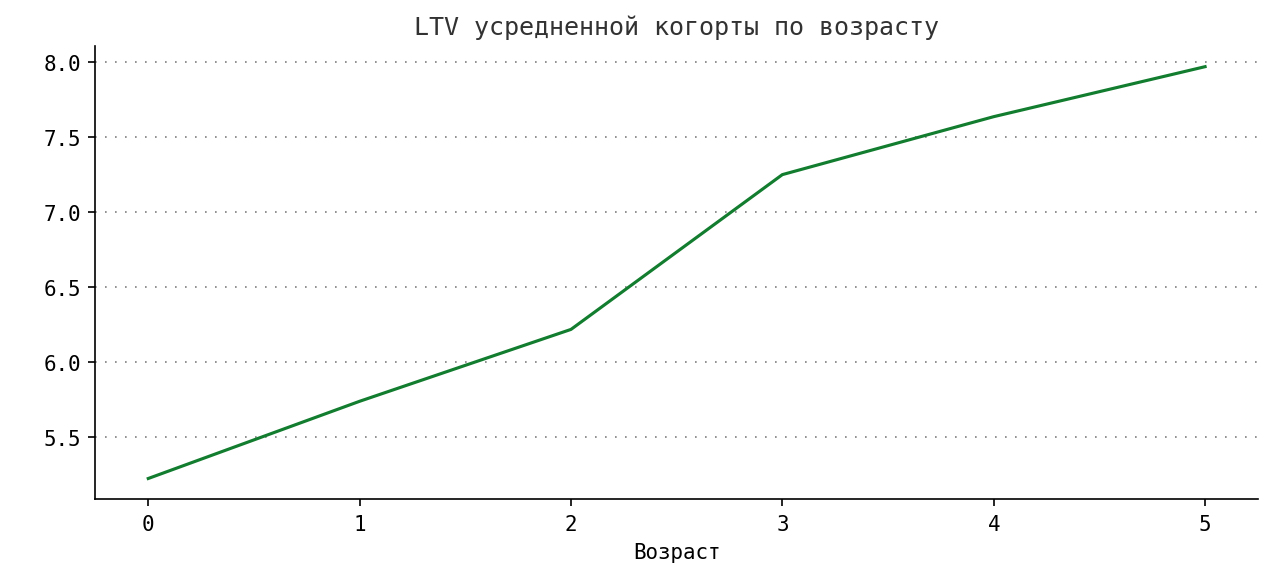

In [97]:
fig = plt.figure(figsize=(10, 4), dpi=150,facecolor='white')

ax0 = fig.add_subplot()
ax0.set_facecolor('white')
ax0.grid(color='black', linestyle=':', axis='y', dashes=(1,5), alpha=0.5)
for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)

ax0.set_title('LTV усредненной когорты по возрасту', fontfamily='monospace', color='#323232')
ax0.set_xlabel('Возраст', fontfamily='monospace')
ax0.set_ylabel(' ')
ax0.tick_params(axis = 'both', which = 'major', labelsize = 10)

sns.lineplot(ax=ax0, data=output.cumsum(axis=1).mean(), color='#137d2f')

plt.show()

Также посчитаю средний LTV на 6 месяц жизни когорты

In [98]:
round(output.cumsum(axis=1)[5].mean(), 2)

7.97

### 6. Маркетинговые метрики <a id='mark_metrics'> </a>

#### 6.1. Траты по источникам <a id='source_cost'> </a>

Для того чтобы посчитать распределение бюджета на маркетинг по источникам трафика сгруппирую датасет `cost` по источникам трафика и потраченные средства просуммирую

In [99]:
marketing_cost = costs.groupby('source_id', as_index=False)['costs'].sum().sort_values('costs', ascending=False)

In [100]:
marketing_cost

,source_id,costs
2,3,"141,321.63"
3,4,"61,073.60"
4,5,"51,757.10"
1,2,"42,806.04"
0,1,"20,833.27"
6,10,"5,822.49"
5,9,"5,517.49"


Посчитаю общую потраченную сумму

In [101]:
round(marketing_cost.costs.sum(), 2)

329131.62

С помощью столбчатой диаграммы визуализирую траты

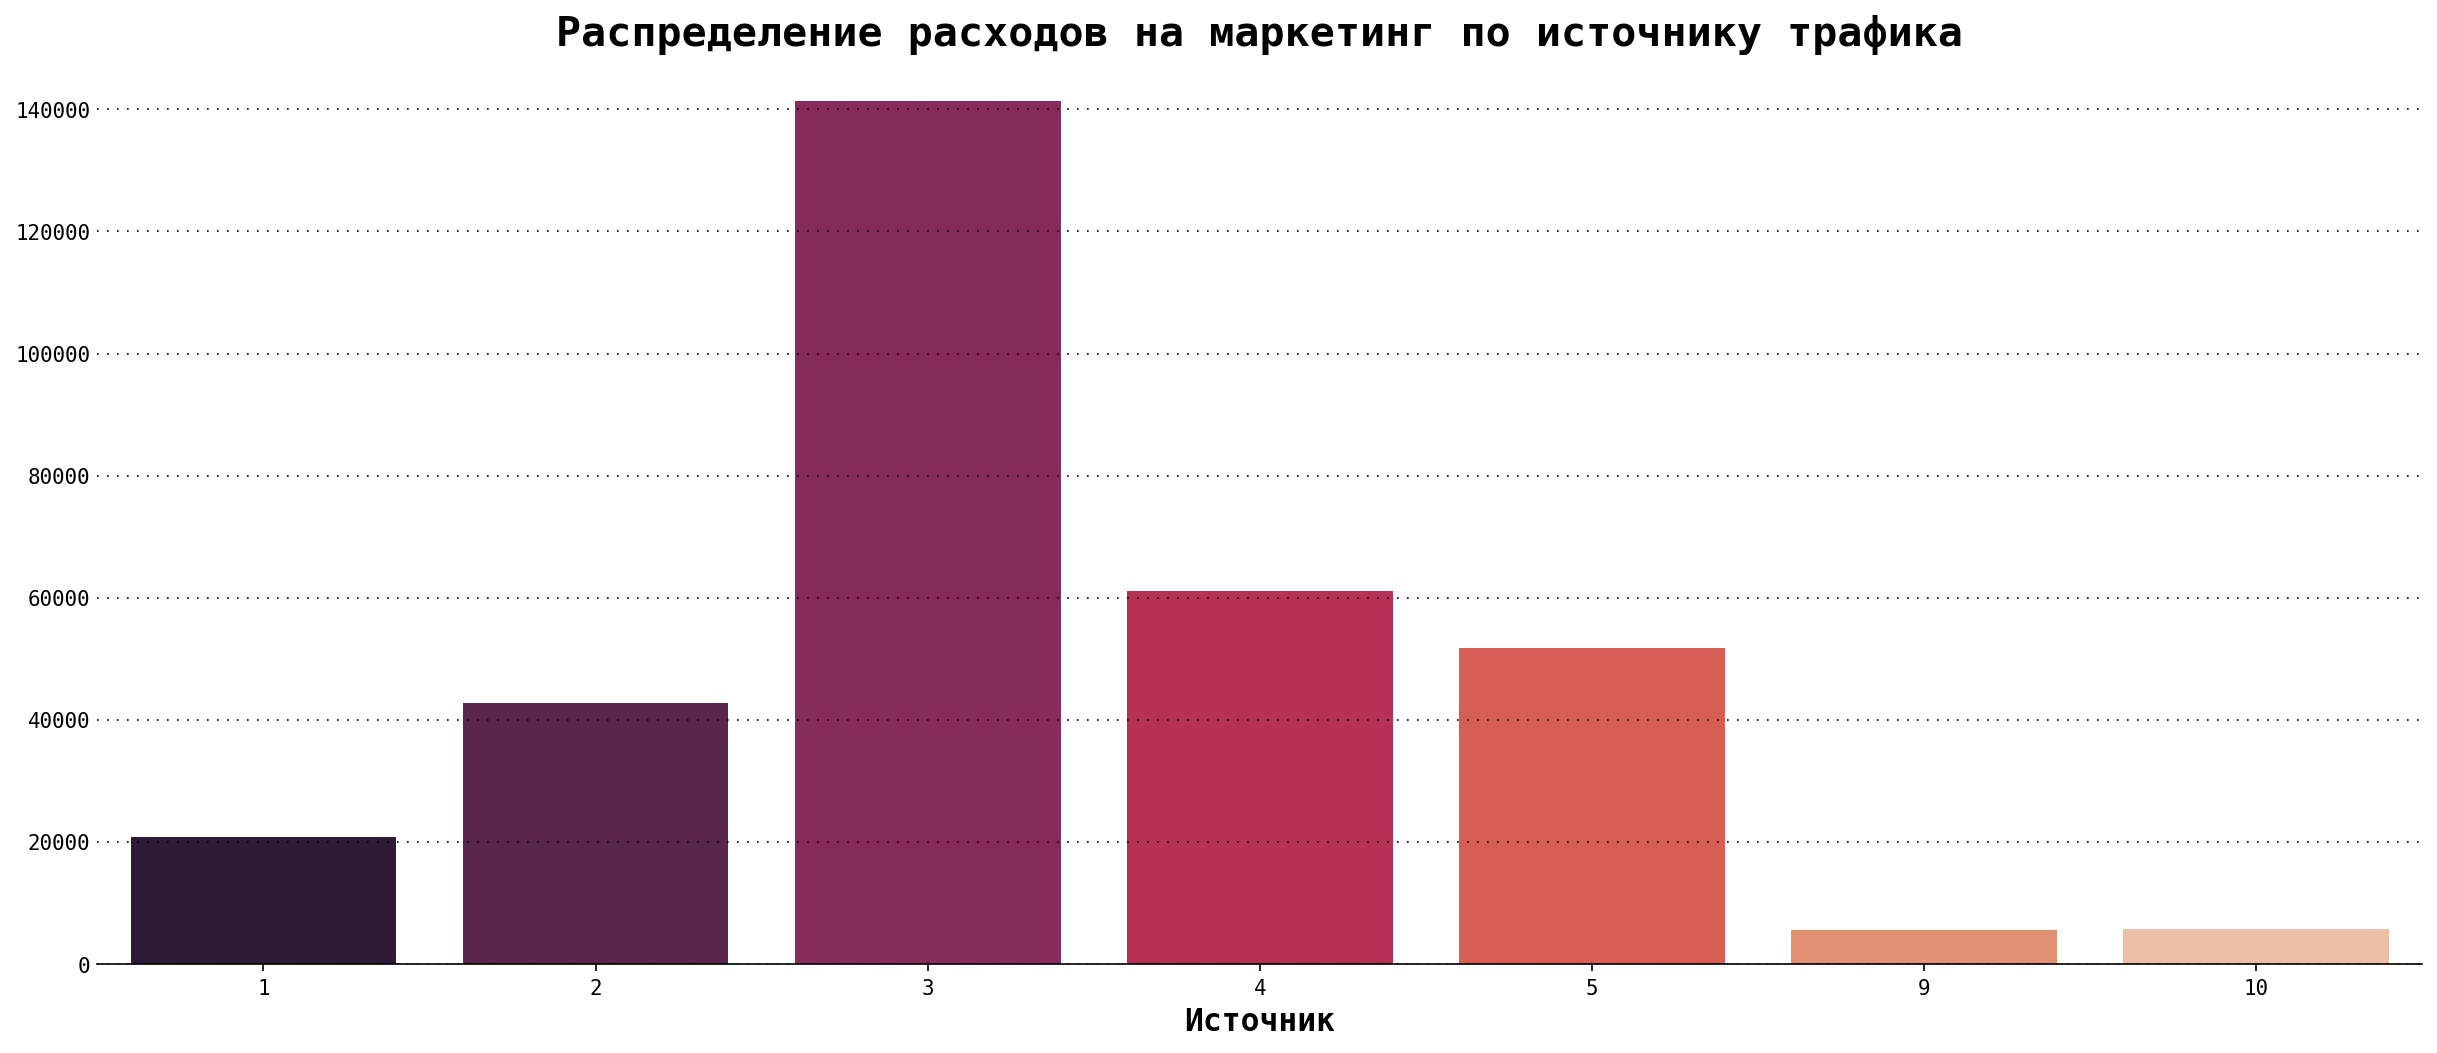

In [102]:
fig = plt.figure(figsize=(20, 8), dpi=150, facecolor='white')

ax=[None]

ax[0]=fig.add_subplot()

ax[0].grid(color='black', linestyle=':', axis='y', zorder=0,  dashes=(1,5))

sns.barplot(
    x='source_id',
    y='costs',
    data=marketing_cost,
    palette='rocket',
    ax=ax[0],
    alpha=1
)

for direction in ['top','right','left']:
    ax[0].spines[direction].set_visible(False)

ax[0].set_xlabel('Источник',fontsize=15, fontweight='bold')


ax[0].tick_params(axis='y',length=0)
ax[0].set_ylabel('')
ax[0].set_title('Распределение расходов на маркетинг по источнику трафика', fontsize=20, fontweight='bold', fontfamily='monospace')

plt.show()

Теперь покажу изменение расходов для каждого источника трафика. Итоги будут с нарастающи итогом, для наглядности.  
  
Для начала добавлю колонку с месяцем. А затем создам сводную таблицу.

In [103]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [104]:
costs['month'] = costs['dt'].astype('datetime64[M]')

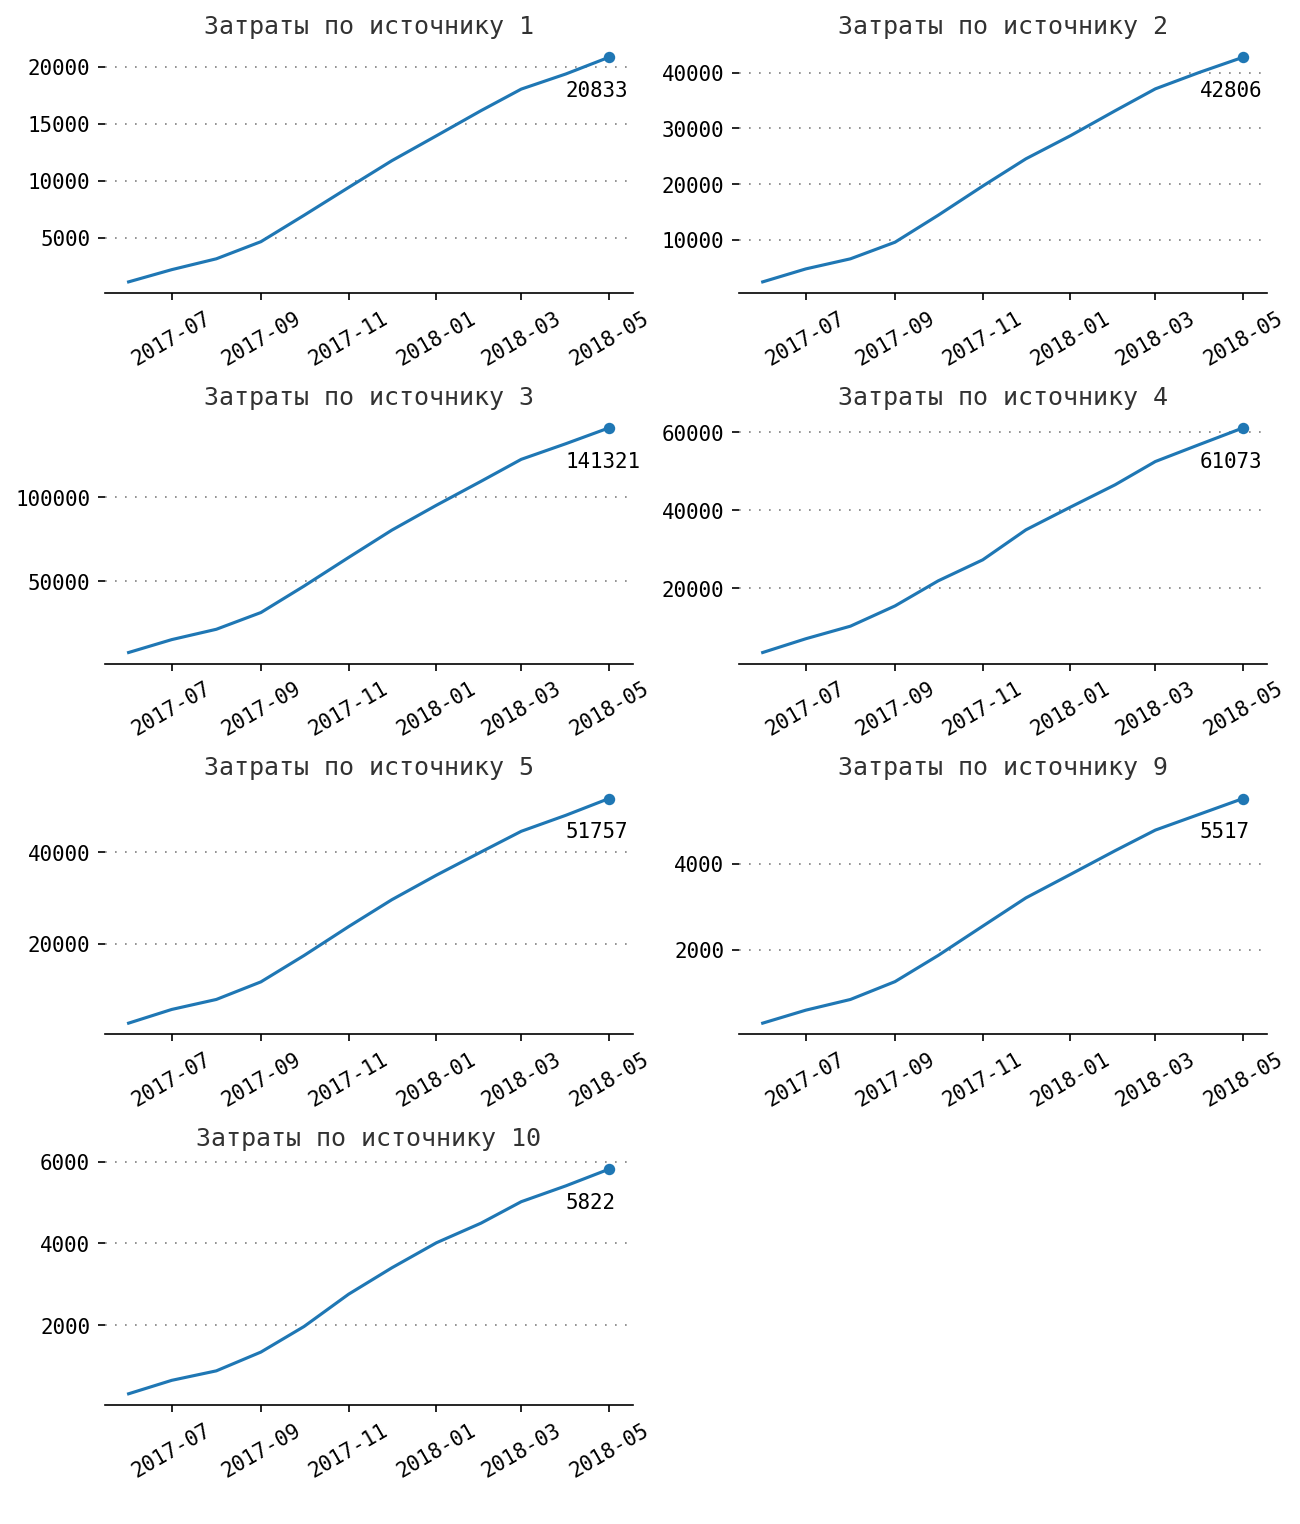

In [105]:
background_color = 'white'
fig = plt.figure(figsize=(10, 12), dpi=150,facecolor='white')
gs = fig.add_gridspec(4, 2) #сетка для графиков
gs.update(wspace=0.2, hspace=0.5) #расстояния


plot = 0
for row in range(0, 4):
    for col in range(0, 2):
        if row == 3 and col == 1: #источников 7, поэтому последний 8-й не нужен
            break
        else:
            locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
            locals()["ax"+str(plot)].set_facecolor(background_color)
            locals()["ax"+str(plot)].tick_params(axis='x', left=False, labelrotation=30)
            locals()["ax"+str(plot)].get_yaxis().set_visible(True)
            locals()["ax"+str(plot)].set_axisbelow(True)
            for s in ["top","right","left"]:
                locals()["ax"+str(plot)].spines[s].set_visible(False)
            plot += 1

plot = 0

sources = list(costs.source_id.unique()) #список источников

for source in sources:
    #срез по конкретному источнику
    data_source = costs.query('source_id == @source').pivot_table(index='month', values='costs', aggfunc='sum')
    max_cost = data_source.cumsum(axis=0).max()[0]
    sns.lineplot(data=data_source.cumsum(axis=0), ax=locals()["ax"+str(plot)], legend=False)
    locals()["ax"+str(plot)].set_title('Затраты по источнику {}'.format(source), fontfamily='monospace', color='#323232')
    locals()["ax"+str(plot)].grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    locals()["ax"+str(plot)].set_xlabel(' ')
    locals()["ax"+str(plot)].text('2018-04-01', max_cost - max_cost/6, int(max_cost))
    locals()["ax"+str(plot)].scatter('2018-05-01', max_cost, s=20)
    plot += 1

plt.show()

Очевидно, что лидером является 3 источник трафика, далее следует 4 и на третьем месте 5.

#### 6.2. Customer Acquisition Cost <a id='cac'> </a>

Расчитаю средний CAC на одного покупателя для всего проекта.  
  
Для этого сначала разделю расходы на месячные когорты  

In [106]:
costs_cohorts = costs.groupby('month', as_index=False) \
    .agg({'costs' : 'sum'}) \
    .rename({'costs' : 'total_cost'})

In [107]:
costs_cohorts.head()

,month,costs
0,2017-06-01,"18,015.00"
1,2017-07-01,"18,240.59"
2,2017-08-01,"14,790.54"
3,2017-09-01,"24,368.91"
4,2017-10-01,"36,322.88"


Теперь нужно найти количество уникальных покупателей для каждой когорты. Для этого сгруппирую `orders` по первому месяцу покупки и посчитаю уникальных

In [108]:
cohort_sizes_orders = orders.groupby('first_month', as_index=False) \
    .agg({'uid': 'nunique'})
cohort_sizes_orders.columns = ['first_month', 'n_buyers']

In [109]:
cohort_sizes_orders.head()

,first_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


И объеденю полученные датасеты

In [110]:
costs_cohorts = pd.merge(
    costs_cohorts,
    cohort_sizes_orders,
    how='left',
    left_on='month',
    right_on='first_month'
)
costs_cohorts = costs_cohorts.drop('first_month', axis=1)

In [111]:
costs_cohorts.head()

,month,costs,n_buyers
0,2017-06-01,"18,015.00",2023
1,2017-07-01,"18,240.59",1923
2,2017-08-01,"14,790.54",1370
3,2017-09-01,"24,368.91",2581
4,2017-10-01,"36,322.88",4340


Теперь для каждой когорты можно найти CAC

In [112]:
costs_cohorts['cac'] = costs_cohorts['costs'] / costs_cohorts['n_buyers']

In [113]:
costs_cohorts.head()

,month,costs,n_buyers,cac
0,2017-06-01,"18,015.00",2023,8.91
1,2017-07-01,"18,240.59",1923,9.49
2,2017-08-01,"14,790.54",1370,10.80
3,2017-09-01,"24,368.91",2581,9.44
4,2017-10-01,"36,322.88",4340,8.37


В таком случае средний CAC будет равен:

In [114]:
round(costs_cohorts.cac.mean(), 2)

9.15

В среднем для привлечения одного покупателя тратилось 9.15 у.е.  
  
Также провизуализирую изменение метрики с течением времени. Пунктирной линией будет показан средний CAC за весь период

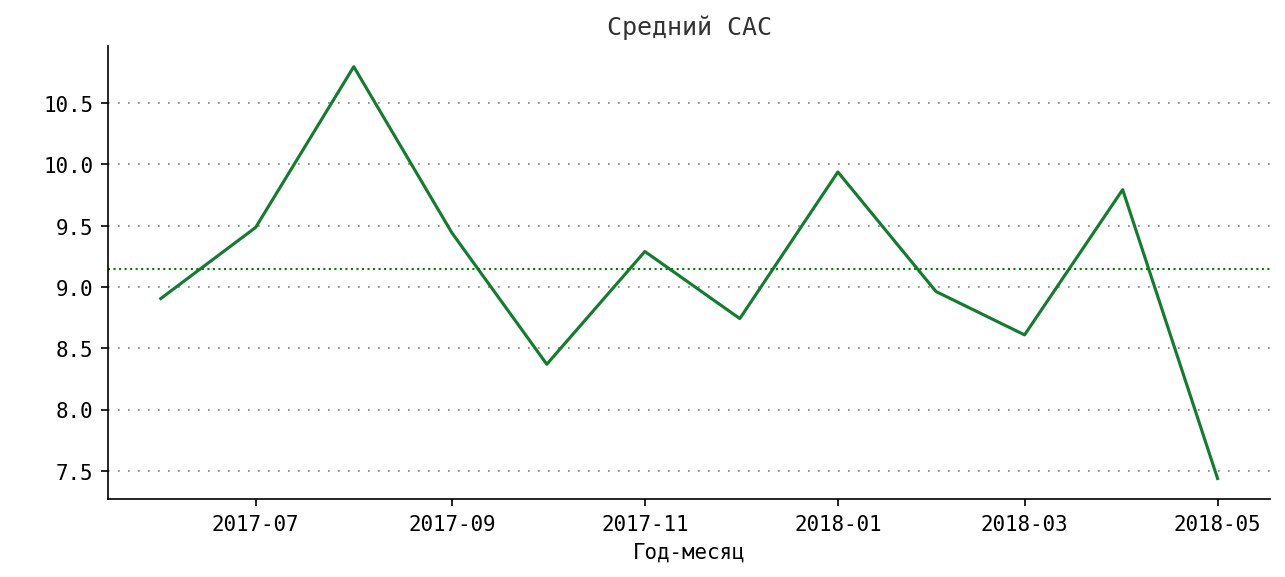

In [115]:
fig = plt.figure(figsize=(10, 4), dpi=150,facecolor='white')

ax0 = fig.add_subplot()
ax0.set_facecolor('white')
ax0.grid(color='black', linestyle=':', axis='y', dashes=(1,5), alpha=0.5)
for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)

ax0.set_title('Средний CAC', fontfamily='monospace', color='#323232')
ax0.set_xlabel('Год-месяц', fontfamily='monospace')
ax0.set_ylabel(' ')
ax0.tick_params(axis = 'both', which = 'major', labelsize = 10)

sns.lineplot(ax=ax0, data=costs_cohorts, x='month', y='cac', color='#137d2f')

ax0.axhline(y=9.15, ls=':', lw='1', ds='steps', c='green')

plt.show()

Теперь расчитаю средний CAC для каждого источника трафика. Для этого сгруппирую датасет `costs` по когортам и источнику

In [116]:
costs_cohorts_source = costs.groupby(['month', 'source_id'], as_index=False) \
    .agg({'costs' : 'sum'}) \
    .rename({'costs' : 'total_cost'})

In [117]:
costs_cohorts_source.head()

,month,source_id,costs
0,2017-06-01,1,"1,125.61"
1,2017-06-01,2,"2,427.38"
2,2017-06-01,3,"7,731.65"
3,2017-06-01,4,"3,514.80"
4,2017-06-01,5,"2,616.12"


Далее расчитаю количество уникальных покупателей по источнику трафика. Для этого приедется взять их из датасета `visits`. Переносить буду источник в самую первую сессию пользователя.  
  
Сначала найду первое посещение

In [118]:
visits_first_source = visits.groupby('uid', as_index=False) \
    .agg({'start_ts' : np.min})

Теперь объеденю полученный датасет с колонками source_id, start_ts по uid. Ну и сброшу дату посещения

In [119]:
visits_first_source = visits_first_source.merge(
    visits[['source_id', 'start_ts', 'uid']],
    on=['uid', 'start_ts'],
    how='left'
)
visits_first_source = visits_first_source.drop('start_ts', axis=1)

Вот что получилось

In [120]:
visits_first_source.head()

,uid,source_id
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5


Теперь объеденю с датасетом `orders`

In [121]:
orders = orders.merge(visits_first_source, on='uid', how='left')

In [122]:
orders.head()

,buy_ts,revenue,uid,month,first_month,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,3


In [123]:
cohort_sizes_source = orders.groupby(['first_month', 'source_id'], as_index=False) \
    .agg({'uid': 'nunique'})
cohort_sizes_source.columns = ['first_month', 'source_id', 'n_users']

In [124]:
cohort_sizes_source.head()

,first_month,source_id,n_users
0,2017-06-01,1,190
1,2017-06-01,2,235
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384


Объединю полученные датасеты

In [125]:
costs_cohorts_source = pd.merge(
    costs_cohorts_source,
    cohort_sizes_source,
    how='left',
    left_on=['month', 'source_id'],
    right_on=['first_month', 'source_id']
)
costs_cohorts_source = costs_cohorts_source.drop('first_month', axis=1)

In [126]:
costs_cohorts_source.head()

,month,source_id,costs,n_users
0,2017-06-01,1,"1,125.61",190
1,2017-06-01,2,"2,427.38",235
2,2017-06-01,3,"7,731.65",638
3,2017-06-01,4,"3,514.80",413
4,2017-06-01,5,"2,616.12",384


Осталось вычислить CAC

In [127]:
costs_cohorts_source['cac'] = costs_cohorts_source['costs'] / costs_cohorts_source['n_users']

In [128]:
costs_cohorts_source.head()

,month,source_id,costs,n_users,cac
0,2017-06-01,1,"1,125.61",190,5.92
1,2017-06-01,2,"2,427.38",235,10.33
2,2017-06-01,3,"7,731.65",638,12.12
3,2017-06-01,4,"3,514.80",413,8.51
4,2017-06-01,5,"2,616.12",384,6.81


Чтобы показать средний CAC для каждой когорты и источника трафика, сначала воспользуюсь тепловой картой

In [129]:
mean_cohort_source = costs_cohorts_source.pivot_table(
    index='month',
    columns='source_id',
    values='cac',
    aggfunc='mean'
)

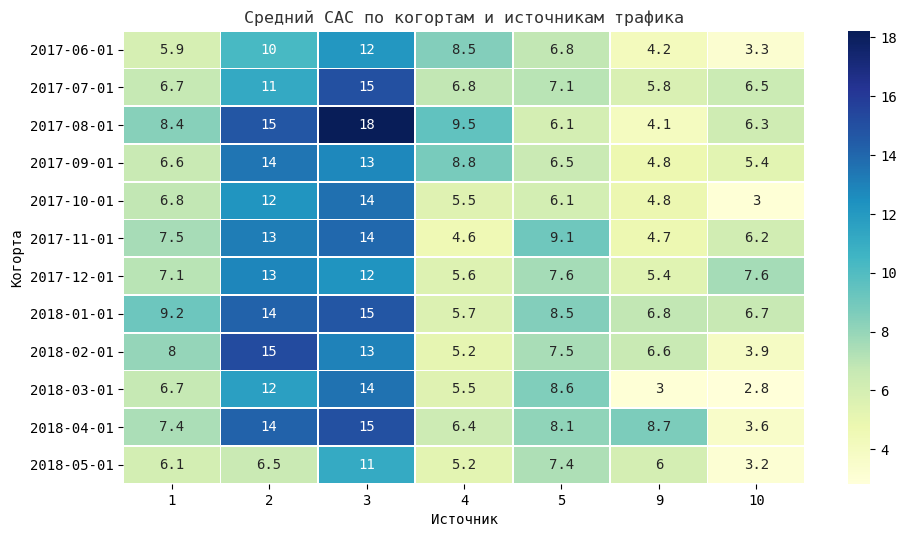

In [130]:
fig = plt.figure(figsize=(11, 6), dpi=100)

ax0 = fig.add_subplot()

background_color = "#fafafa"
fig.patch.set_facecolor('white')
ax0.set_facecolor(background_color)

ticks_labels_source = list(costs_cohorts_source['month'].astype('datetime64[M]').astype(str).unique())
ax0.set_title('Средний CAC по когортам и источникам трафика', fontfamily='monospace', color='#323232')

sns.heatmap(ax=ax0, data=mean_cohort_source, yticklabels=ticks_labels_source, xticklabels=True, annot=True, linewidths=0.5, cmap="YlGnBu")

ax0.set_xlabel('Источник', fontfamily='monospace')
ax0.set_ylabel('Когорта')

plt.show()

И чтобы показать динамику среднего CAC начерчу линейный график

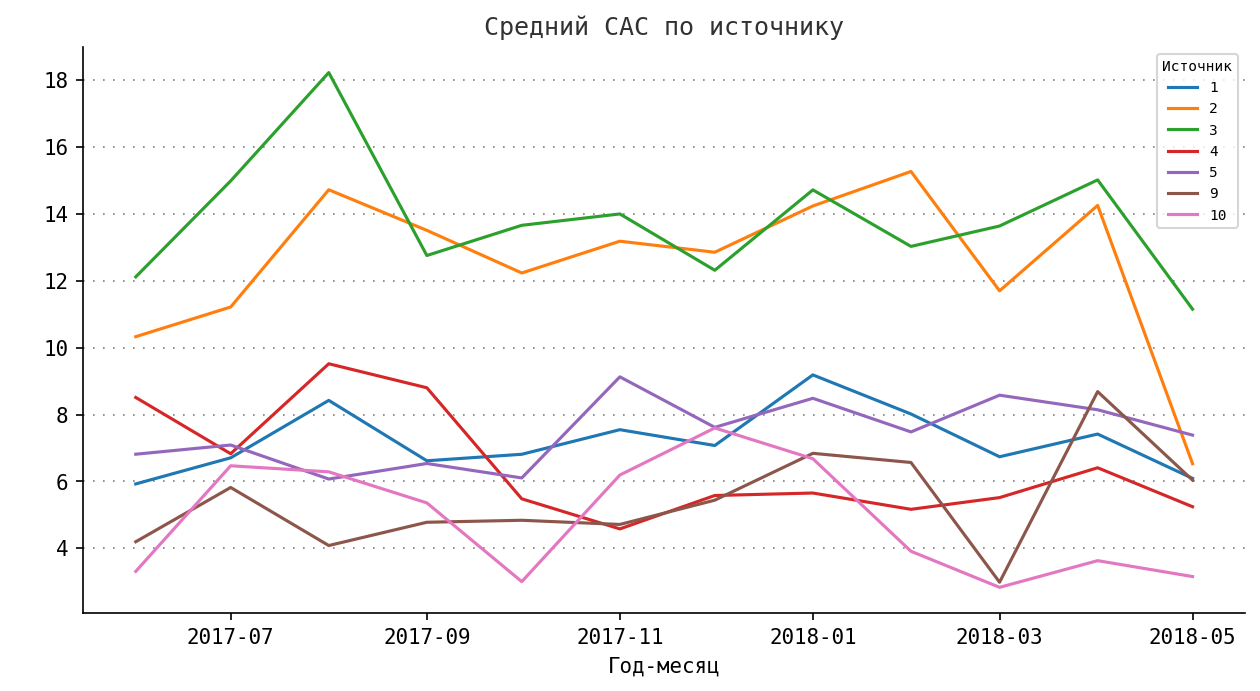

In [131]:
fig = plt.figure(figsize=(10, 5), dpi=150,facecolor='white')

ax0 = fig.add_subplot()
ax0.set_facecolor('white')
ax0.grid(color='black', linestyle=':', axis='y', dashes=(1,5), alpha=0.5)
for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)

ax0.set_title('Средний CAC по источнику', fontfamily='monospace', color='#323232')
ax0.set_xlabel('Год-месяц', fontfamily='monospace')
ax0.set_ylabel(' ')
ax0.tick_params(axis = 'both', which = 'major', labelsize = 10)

sns.lineplot(ax=ax0, data=costs_cohorts_source, x='month', y='cac', hue='source_id', palette='tab10')

ax0.legend(title='Источник', fontsize ='x-small', title_fontsize ='x-small')

plt.show()

#### 6.3. Return on Marketing Investment <a id='romi'> </a>

Сначала посчитаю ROMI по когортам. А затем в разрезе источников, то есть для каждого источника отдельно.

Уже имеется датасет с LTV за 6 месяцев. Воспользуюсь им и добавлю к нему CAC

In [132]:
report.head()

,first_month,n_buyers,month,revenue,age,ltv
0,2017-06-01,2023,2017-06-01,"9,557.49",0,4.72
1,2017-06-01,2023,2017-07-01,981.82,1,0.49
2,2017-06-01,2023,2017-08-01,885.34,2,0.44
3,2017-06-01,2023,2017-09-01,"1,931.30",3,0.95
4,2017-06-01,2023,2017-10-01,"2,068.58",4,1.02


In [133]:
costs_cohorts.head()

,month,costs,n_buyers,cac
0,2017-06-01,"18,015.00",2023,8.91
1,2017-07-01,"18,240.59",1923,9.49
2,2017-08-01,"14,790.54",1370,10.80
3,2017-09-01,"24,368.91",2581,9.44
4,2017-10-01,"36,322.88",4340,8.37


In [134]:
costs_cohorts = costs_cohorts.rename({'month' : 'first_month'}, axis=1)
report_romi = pd.merge(
    report,
    costs_cohorts[['first_month', 'cac']],
    how='left',
    on='first_month'
)

In [135]:
report_romi.head()

,first_month,n_buyers,month,revenue,age,ltv,cac
0,2017-06-01,2023,2017-06-01,"9,557.49",0,4.72,8.91
1,2017-06-01,2023,2017-07-01,981.82,1,0.49,8.91
2,2017-06-01,2023,2017-08-01,885.34,2,0.44,8.91
3,2017-06-01,2023,2017-09-01,"1,931.30",3,0.95,8.91
4,2017-06-01,2023,2017-10-01,"2,068.58",4,1.02,8.91


In [136]:
report_romi['romi'] = report_romi['ltv'] / report_romi['cac']

Составлю сводную таблицу

In [137]:
romi_by_cohorts = report_romi.query('age < 6').pivot_table(
    index='first_month',
    columns='age',
    values='romi',
    aggfunc='mean'
)

In [138]:
romi_by_cohorts.cumsum(axis=1).round(2)

age,0,1,2,3,4,5
first_month,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.30
2017-10-01,0.60,0.66,0.68,0.70,0.72,0.74
2017-11-01,0.55,0.60,0.62,0.65,0.67,0.68
2017-12-01,0.54,0.57,0.68,0.80,0.84,0.87


In [139]:
romi_by_cohorts.cumsum(axis=1).mean(axis=0)

age
0   0.56
1   0.62
2   0.67
3   0.78
4   0.82
5   0.86
dtype: float64

Также посмотрю на тепловой карте результаты

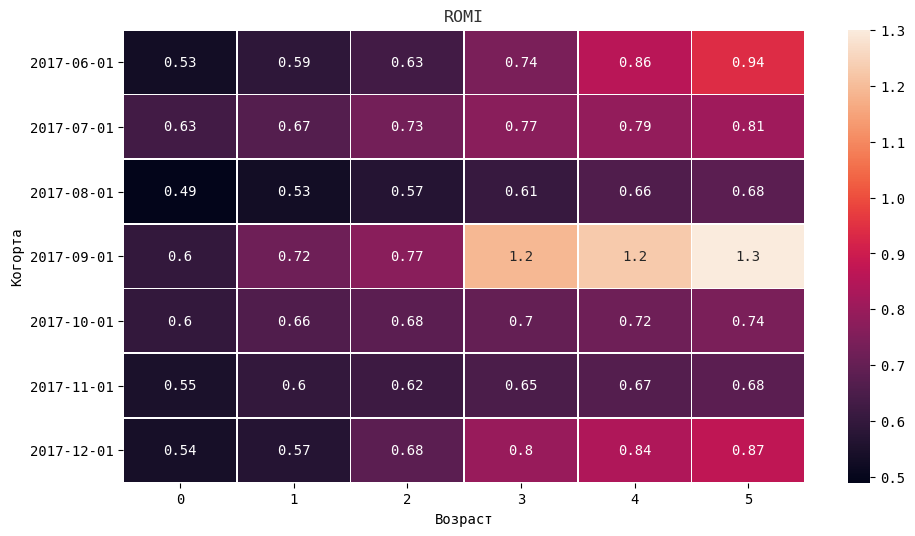

In [140]:
fig = plt.figure(figsize=(11, 6), dpi=100)

ax0 = fig.add_subplot()

background_color = "#fafafa"
fig.patch.set_facecolor('white')
ax0.set_facecolor(background_color)

ticks_labels_source = list(report_romi['first_month'].astype('datetime64[M]').astype(str).unique())
ax0.set_title('ROMI', fontfamily='monospace', color='#323232')

sns.heatmap(ax=ax0, data=romi_by_cohorts.cumsum(axis=1).round(2), yticklabels=ticks_labels_source, xticklabels=True, annot=True, linewidths=0.5)

ax0.set_xlabel('Возраст', fontfamily='monospace')
ax0.set_ylabel('Когорта')

plt.show()

Как видно за 6 месяцев вложения не окупаются у всех когорт кроме сентябрьское. Но тут включены все источники трафика. Проверим каждый по отдельности. Возможно какие-то источники все таки являются прибыльными.
  
Для этого необходимо посчитать LTV по источника

In [141]:
cohorts_source_size = orders.groupby(['first_month', 'source_id'], as_index=False) \
    .agg({'uid' : 'nunique'}) \
    .rename({'uid' : 'n_buyers'}, axis=1)

In [142]:
cohorts_source_size.head()

,first_month,source_id,n_buyers
0,2017-06-01,1,190
1,2017-06-01,2,235
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384


In [143]:
cohorts_source = orders.groupby(['first_month', 'source_id', 'month'], as_index=False) \
    .agg({'revenue' : 'sum'}) \
    .rename({'revenue' : 'total_revenue'}, axis=1)

In [144]:
cohorts_source.head()

,first_month,source_id,month,total_revenue
0,2017-06-01,1,2017-06-01,"1,378.70"
1,2017-06-01,1,2017-07-01,414.98
2,2017-06-01,1,2017-08-01,419.43
3,2017-06-01,1,2017-09-01,714.24
4,2017-06-01,1,2017-10-01,811.20


Объединю полученные датасеты

In [145]:
report_source = pd.merge(
    cohorts_source_size,
    cohorts_source,
    on=['first_month', 'source_id']
)

In [146]:
report_source.head()

,first_month,source_id,n_buyers,month,total_revenue
0,2017-06-01,1,190,2017-06-01,"1,378.70"
1,2017-06-01,1,190,2017-07-01,414.98
2,2017-06-01,1,190,2017-08-01,419.43
3,2017-06-01,1,190,2017-09-01,714.24
4,2017-06-01,1,190,2017-10-01,811.20


Расчитаю возраст каждой когорты

In [147]:
report_source['age'] = (
    report_source['month']
    - report_source['first_month']
) / np.timedelta64(1, 'M')
report_source['age'] = report_source['age'].round().astype('int')

In [148]:
report_source.head()

,first_month,source_id,n_buyers,month,total_revenue,age
0,2017-06-01,1,190,2017-06-01,"1,378.70",0
1,2017-06-01,1,190,2017-07-01,414.98,1
2,2017-06-01,1,190,2017-08-01,419.43,2
3,2017-06-01,1,190,2017-09-01,714.24,3
4,2017-06-01,1,190,2017-10-01,811.20,4


Так как у нас маржинальность 100%, то вся выручка и есть валовая прибыль

In [149]:
report_source['ltv'] = report_source['total_revenue'] / report_source['n_buyers']

In [150]:
report_source.head()

,first_month,source_id,n_buyers,month,total_revenue,age,ltv
0,2017-06-01,1,190,2017-06-01,"1,378.70",0,7.26
1,2017-06-01,1,190,2017-07-01,414.98,1,2.18
2,2017-06-01,1,190,2017-08-01,419.43,2,2.21
3,2017-06-01,1,190,2017-09-01,714.24,3,3.76
4,2017-06-01,1,190,2017-10-01,811.20,4,4.27


LTV расчитал, теперь необходимо включить сюда CAC, который уже расчитан

In [151]:
costs_cohorts_source.head()

,month,source_id,costs,n_users,cac
0,2017-06-01,1,"1,125.61",190,5.92
1,2017-06-01,2,"2,427.38",235,10.33
2,2017-06-01,3,"7,731.65",638,12.12
3,2017-06-01,4,"3,514.80",413,8.51
4,2017-06-01,5,"2,616.12",384,6.81


In [152]:
costs_cohorts_source.columns = ['first_month', 'source_id', 'costs', 'n_users', 'cac']
report_source_romi = pd.merge(
    report_source,
    costs_cohorts_source[['first_month', 'source_id', 'cac']],
    on=['first_month', 'source_id']
)

In [153]:
report_source_romi.head()

,first_month,source_id,n_buyers,month,total_revenue,age,ltv,cac
0,2017-06-01,1,190,2017-06-01,"1,378.70",0,7.26,5.92
1,2017-06-01,1,190,2017-07-01,414.98,1,2.18,5.92
2,2017-06-01,1,190,2017-08-01,419.43,2,2.21,5.92
3,2017-06-01,1,190,2017-09-01,714.24,3,3.76,5.92
4,2017-06-01,1,190,2017-10-01,811.20,4,4.27,5.92


In [154]:
report_source_romi['romi'] = report_source_romi['ltv'] / report_source_romi['cac']

Теперь визуализируем окупаемость по каждому источнику. Красной линией будет отмечен барьер окупаемости, если переваливает за него, значит средняя когорта по источнику окупается

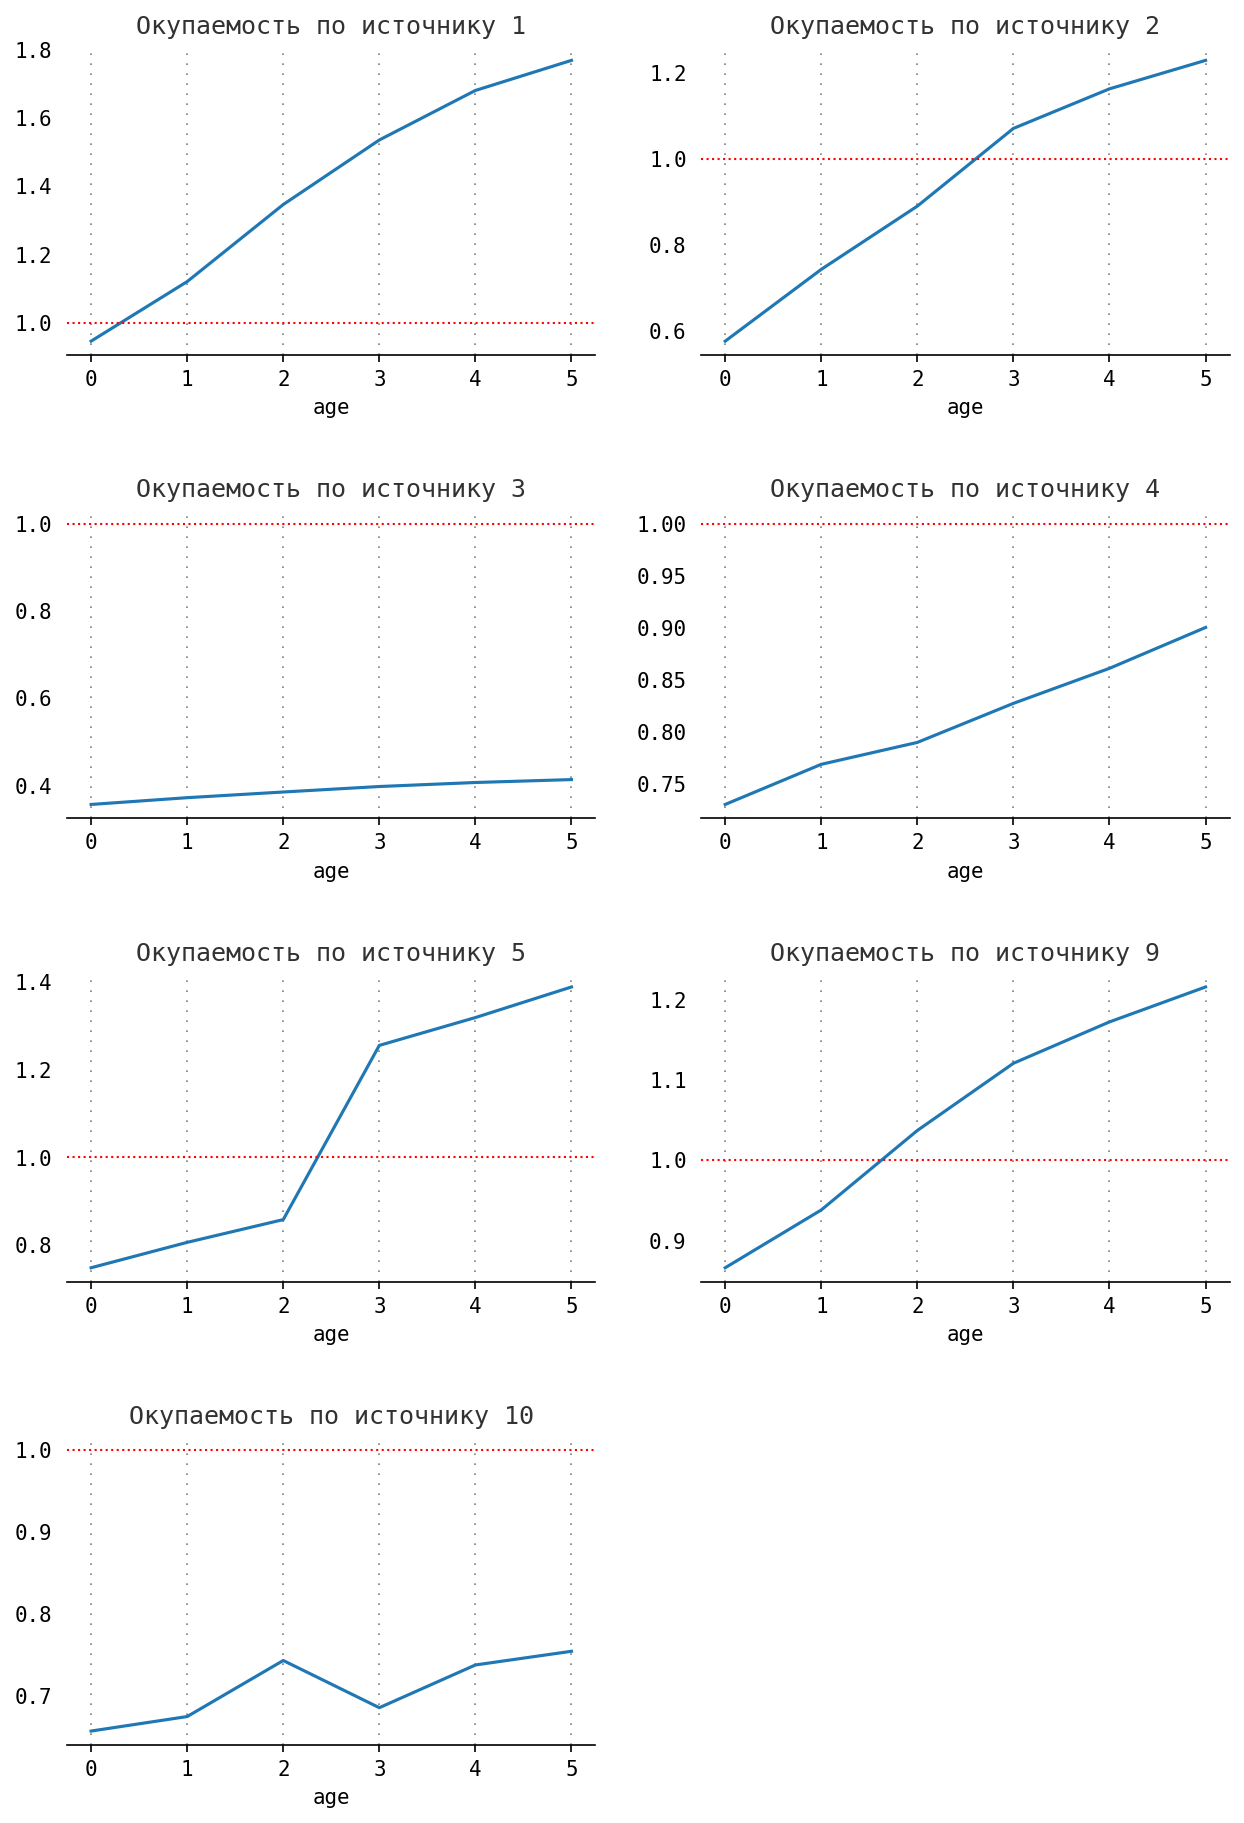

In [155]:
background_color = 'white'
fig = plt.figure(figsize=(10, 15), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(4, 2) #сетка для графиков
gs.update(wspace=0.2, hspace=0.5) #расстояния


plot = 0
for row in range(0, 4):
    for col in range(0, 2):
        if row == 3 and col == 1: #источников 7, поэтому последний 8-й не нужен
            break
        else:
            locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
            locals()["ax"+str(plot)].set_facecolor(background_color)
            locals()["ax"+str(plot)].tick_params(axis='y', left=False)
            locals()["ax"+str(plot)].get_yaxis().set_visible(True)
            locals()["ax"+str(plot)].set_axisbelow(True)
            for s in ["top","right","left"]:
                locals()["ax"+str(plot)].spines[s].set_visible(False)
            plot += 1

plot = 0

sources = list(report_source_romi.source_id.unique()) #список источников

for source in sources:
    #срез по конкретному источнику
    data_source = report_source_romi \
        .query('age < 6 & first_month < "2018-01-01" & source_id == @source') \
        .pivot_table(
            index=['source_id', 'first_month'],
            columns='age',
            values='romi',
            aggfunc='mean'
        )
    sns.lineplot(data=data_source.cumsum(axis=1).mean(axis=0), ax=locals()["ax"+str(plot)])
    locals()["ax"+str(plot)].set_title('Окупаемость по источнику {}'.format(source), loc='center', fontfamily='monospace', color='#323232')
    locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    locals()["ax"+str(plot)].axhline(y=1, ls=':', lw='1', ds='steps', c='red')
    plot += 1

plt.show()

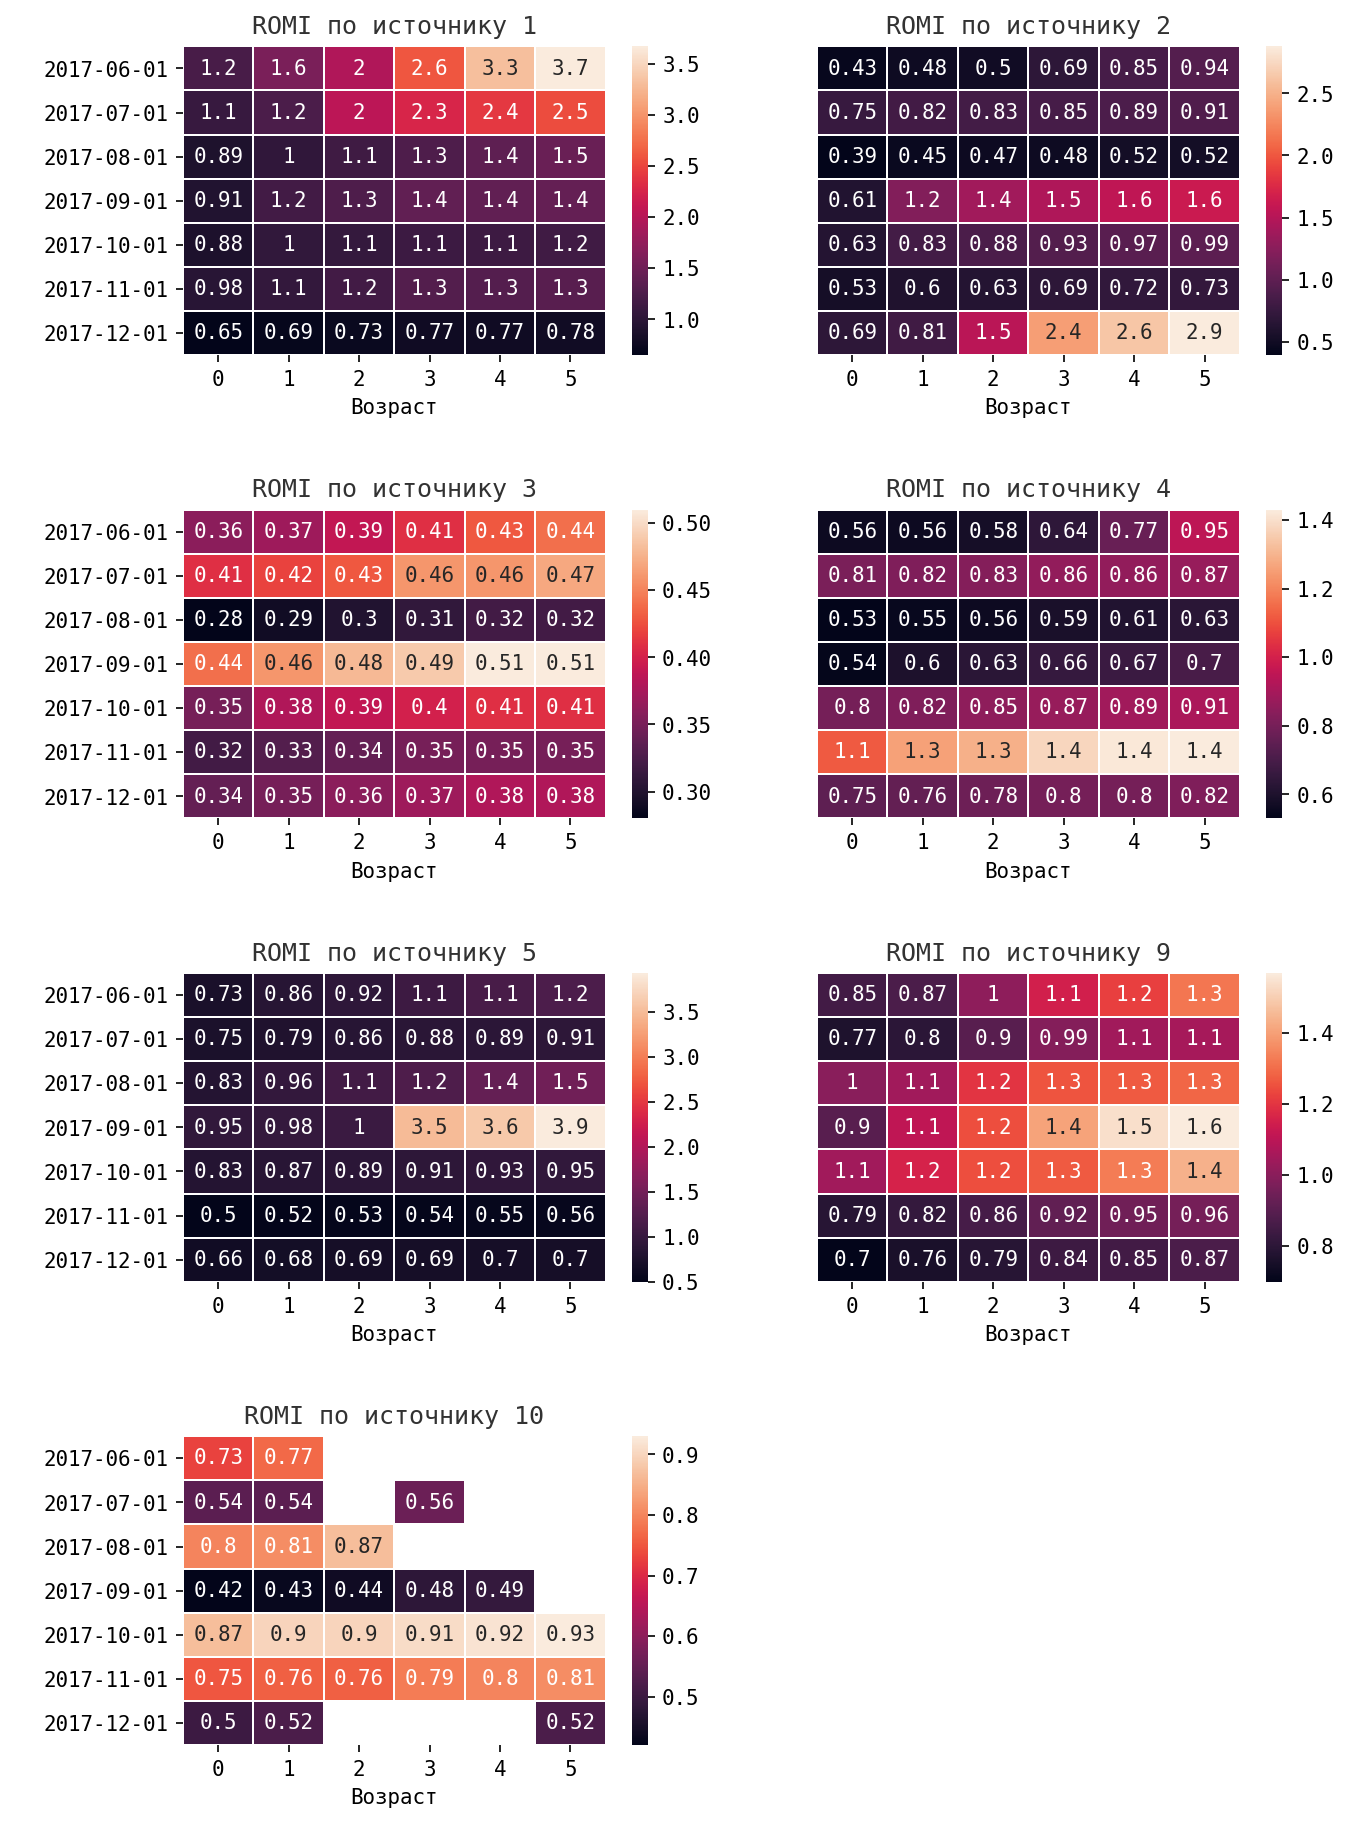

In [156]:
background_color = 'white'
fig = plt.figure(figsize=(10, 15), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(4, 2) #сетка для графиков
gs.update(wspace=0.2, hspace=0.5) #расстояния


plot = 0
for row in range(0, 4):
    for col in range(0, 2):
        if row == 3 and col == 1: #источников 7, поэтому последний 8-й не нужен
            break
        else:
            locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
            locals()["ax"+str(plot)].set_facecolor(background_color)
            locals()["ax"+str(plot)].tick_params(axis='y', left=True)
            locals()["ax"+str(plot)].set_axisbelow(True)
            for s in ["top","right","left"]:
                locals()["ax"+str(plot)].spines[s].set_visible(False)
            plot += 1

plot = 0

sources = list(report_source_romi.source_id.unique()) #список источников
ticks_labels_cohorts = list(report_source_romi[report_source_romi['first_month'] < "2018-01-01"]['first_month'].astype('datetime64[M]').astype(str).unique())

for i, source in enumerate(sources):
    #срез по конкретному источнику
    data_source = report_source_romi \
        .query('age < 6 & first_month < "2018-01-01" & source_id == @source') \
        .pivot_table(
            index='first_month',
            columns='age',
            values='romi',
            aggfunc='mean'
        ).cumsum(axis=1).round(2)
    if i%2 > 0:
        sns.heatmap(data=data_source, ax=locals()["ax"+str(plot)], yticklabels=ticks_labels_cohorts, annot=True, linewidths=0.5, cbar=True)
        locals()["ax"+str(plot)].set_title('ROMI по источнику {}'.format(source), fontfamily='monospace', color='#323232')
        locals()["ax"+str(plot)].set_ylabel(' ')
        locals()["ax"+str(plot)].set_xlabel('Возраст', fontfamily='monospace')
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
    else:
        sns.heatmap(data=data_source, ax=locals()["ax"+str(plot)], yticklabels=ticks_labels_cohorts, annot=True, linewidths=0.5, cbar=True)
        locals()["ax"+str(plot)].set_title('ROMI по источнику {}'.format(source), fontfamily='monospace', color='#323232')
        locals()["ax"+str(plot)].set_ylabel(' ')
        locals()["ax"+str(plot)].set_xlabel('Возраст', fontfamily='monospace')
        locals()["ax"+str(plot)].get_yaxis().set_visible(True)
    plot += 1

plt.show()

Как видно из диаграм, окупаются только 1, 2, 5 и 9 источники за 6 лет жизни когорт. При чем 1 источник окупается на следующий месяц после первого.

### 7. Выводы и рекомендации <a id='conclusions'> </a>

#### Перспективные источники трафика

Как было видно из расчетов ROMI по источникам, окупаемые как минимум к четвертому месяцу являются 4 источника трафика. Это 1, 2, 5 и 9. Остальные источники не окупаются даже за 6 месяцев. Поэтому рекомендую сделать упор на вышеназванные источники так как они приносят прибыль.  
  
При чем первый источник окупается практически сразу. Очень перспективное направление. Далее по скорости окупаемости следует 9 источник. На третий месяц жизни он уже начинает приносить прибыль. Оставшиеся два приносят прибыль на 4 месяц жизни, что тоже неплохо.  
  
Если судить по расходам, то больше всего денег было вложено в 3, 4 и 5 источники. 5-й хоть окупился, а вот 3 и 4 нет от слова "совсем". Стоит пересмотреть распределение трат на источники.  

#### Метрики. Выводы

Retention Rate показал, что удержание пользователей на второй месяц составляет всего 5%. Но дальше снижение имеется, но оно не сильно значимо. Самая старая когорта на второй месяц имела 7.9% и далее на 12-й месяц жизни имела 4.5%. Это говорит, что удержание очень хорошее. Возможно, если после первого месяца удасться удерживать в среднем больше чем 5%, то аудитория возрастет существенно.

Медианное время с момента первой активности до покупки составляет. Думаю, есть возможность улучшить эту метрику, если проанализировать путь пользователя. Возможно регистрация карты занимает много времени. Может можно что-то с этим сделать

Ни среднее количество, ни медианное не радуют. Всего около 1 покупки на пользователя. Необходимо продумать как сделать так, чтобы пользователи покупали более одного раза

Средний чек очень существенно просел к концу расматриваемого периода. Стоит задуматься как вернуть его к прежним значениям, а в идеале улучшить.

3.3. Подведите итоги когортного анализа. Определите самые перспективные для компании когорты клиентов;

#### Итоги когортного анализа

Если рассматривать когорты по отдельности, то самой успешной была когорта 2017-09-01. Ее LTV самый большой и составляет 12.31 у.е. У нее же и самый высокий Retention Rate на второй месяц жизни - 8.5. Это единственная когорта, которая окупилась, если судить по ее ROMI по всем источникам. В сентябре 2017-го удалось привлечь удивить пользователей, так что они остались лояльными и принесли хорошие деньги.

In [157]:
report_source_romi \
        .query('age < 6 & first_month == "2017-09-01"') \
        .pivot_table(
            index=['source_id', 'first_month'],
            columns='age',
            values='romi',
            aggfunc='mean'
        ).cumsum(axis=1)

,age,0,1,2,3,4,5
source_id,first_month,,,,,,
1,2017-09-01,0.91,1.18,1.27,1.41,1.41,1.43
2,2017-09-01,0.61,1.21,1.39,1.46,1.56,1.63
3,2017-09-01,0.44,0.46,0.48,0.49,0.51,0.51
4,2017-09-01,0.54,0.60,0.63,0.66,0.67,0.70
5,2017-09-01,0.95,0.98,1.03,3.50,3.62,3.93
9,2017-09-01,0.90,1.11,1.25,1.41,1.54,1.57
10,2017-09-01,0.42,0.43,0.44,0.48,0.49,nan


Как видно из среза, пятый источник на 4-й месяц жизни вырос в три раза. Думаю стоит проанализировать как так получилось. В будущем такое может быть очень полезно